# Functions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm.auto import tqdm
import itertools
import random
import os
import pandas as pd
import itertools
import time

## SpatialConfig

In [ ]:
# ===============================================================
# Configuration and Constants
# ===============================================================

class SpatialConfig:
    """Configuration settings for spatial representation experiments."""

    # Grid representation
    GRID_SIZE = (9, 9, 9)

    # Object IDs for grid representation
    OBJECTS = {
        "chair": 1, "table": 2, "car": 3, "lamp": 4, "box": 5,
        "book": 6, "vase": 7, "plant": 8, "computer": 9, "phone": 10
    }

    # Mapping of spatial relations to relative positions in 3D grid
    SPATIAL_MAP = {
        # horizontal (x)
        "left": (-2, 0, 0),
        "right": (2, 0, 0),

        # depth (y)
        "in_front": (0, 2, 0),
        "front": (0, 2, 0),
        "behind": (0, -2, 0),
        "back": (0, -2, 0),

        # vertical (z)
        "above": (0, 0, 2),
        "below": (0, 0, -2),

        # diagonal
        "diagonally_front_left": (-2, 2, 0),
        "diagonally_front_right": (2, 2, 0),
        "diagonally_back_left": (-2, -2, 0),
        "diagonally_back_right": (2, -2, 0),

        # 3D combinations
        "above_and_left": (-2, 0, 2),
        "above_and_right": (2, 0, 2),
        "below_and_left": (-2, 0, -2),
        "below_and_right": (2, 0, -2),
        "above_and_in_front": (0, 2, 2),
        "above_and_behind": (0, -2, 2),
        "below_and_in_front": (0, 2, -2),
        "below_and_behind": (0, -2, -2),
        "to_the_left_diagonally": (-2, 1, 0),
        "to_the_right_diagonally": (2, 1, 0),
        "left_front": (-2, 2, 0),
        "right_front": (2, 2, 0),
        "left_back": (-2, -2, 0),
        "right_back": (2, -2, 0)
    }

    # Relationship categories
    RELATIONSHIP_CATEGORIES = {
        "vertical": ["above", "below", "above_and_in_front", "above_and_behind",
                    "below_and_in_front", "below_and_behind"],
        "horizontal": ["left", "right", "above_and_left", "above_and_right",
                      "below_and_left", "below_and_right"],
        "depth": ["in_front", "front", "behind", "back"],
        "diagonal": ["diagonally_front_left", "diagonally_front_right",
                    "diagonally_back_left", "diagonally_back_right",
                    "to_the_left_diagonally", "to_the_right_diagonally",
                    "left_front", "right_front", "left_back", "right_back",
                    "diagonally_front_right", "diagonally_front_left",
                    "diagonally_back_right", "diagonally_back_left",
                    "left_diagonally", "right_diagonally"]
    }

    # Mapping from relationship to category
    @classmethod
    def get_relationship_to_category_map(cls):
        """Creates mapping from each relationship to its category."""
        relationship_to_category = {}
        for category, relations in cls.RELATIONSHIP_CATEGORIES.items():
            for relation in relations:
                relationship_to_category[relation] = category
        return relationship_to_category


## LanguageModel

In [ ]:
# ===============================================================
# Language Model Interface
# ===============================================================

class LanguageModelHandler:
    """Handles loading and interacting with the language model."""

    def __init__(self, model_name="meta-llama/Llama-3.2-3B", token=None):
        """
        Initialize the language model handler.

        Args:
            model_name (str): The Hugging Face model name or path.
            token (str): Hugging Face authentication token.
        """
        print(f"Loading language model: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            output_hidden_states=True,
            token=token
        ).cuda()
        self.model.eval()

        # Set padding token
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.tokenizer.pad_token_id = self.tokenizer.eos_token_id

        # Cache model dimensions
        self.d_model = self.model.config.hidden_size

    def get_last_token_activation(self, text):
        """
        Get the activation of the last token in the input text.

        Args:
            text (str): Input text

        Returns:
            torch.Tensor: Activation vector for the last token
        """
        tokens = self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True
        )["input_ids"].cuda()

        with torch.no_grad():
            outputs = self.model(tokens, output_hidden_states=True)

        # Get last token's activation from the last layer
        last_token_idx = tokens.shape[1] - 1
        last_token_activation = outputs.hidden_states[-1][:, last_token_idx, :]

        return last_token_activation.squeeze(0)

    def generate_response(self, prompt, max_new_tokens=10):
        """
        Generate a response to a prompt.

        Args:
            prompt (str): The input prompt
            max_new_tokens (int): Maximum number of tokens to generate

        Returns:
            str: Generated response (processed to extract directional term)
        """
        # Format the prompt to encourage one-word answers
        formatted_prompt = f"{prompt} Respond with one word:"

        inputs = self.tokenizer(formatted_prompt, return_tensors="pt").to(self.model.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                num_return_sequences=1,
                pad_token_id=self.tokenizer.eos_token_id,
                temperature=0.3,  # Lower temperature for more deterministic responses
                do_sample=False,  # Use greedy decoding for consistency
                top_p=1.0
            )

        response = self.tokenizer.decode(
            outputs[0][inputs.input_ids.shape[1]:],
            skip_special_tokens=True
        )

        # Process to extract just the directional term
        directional_terms = ["left", "right", "above", "below", "in front", "behind"]
        for term in directional_terms:
            if term in response.lower():
                return term

        # If no clear term found, return the first word
        first_word = response.strip().split()[0].lower() if response.strip() else ""
        return first_word

    def evaluate_response(self, response, expected_answers):
        """
        Check if the response matches any of the expected answers.

        Args:
            response (str): The generated response
            expected_answers (list): List of acceptable answers

        Returns:
            bool: True if the response matches any expected answer
        """
        response = response.lower()

        for answer in expected_answers:
            if answer.lower() == response or answer.lower() in response:
                return True

        return False

## SpatialDataProcessor

In [ ]:
# ===============================================================
# Spatial Data Processor
# ===============================================================

class SpatialDataProcessor:
    """Processes spatial relationship data for training and evaluation."""

    def __init__(self, config=SpatialConfig):
        """
        Initialize the spatial data processor.

        Args:
            config: Configuration object containing spatial settings
        """
        self.config = config
        self.relationship_to_category = config.get_relationship_to_category_map()

    def normalize_relation(self, relation):
        """
        Normalize spatial relation strings to standard format.

        Args:
            relation (str): The relation string to normalize

        Returns:
            str: Normalized relation string
        """
        relation = relation.lower().strip()
        relation = relation.replace(" of", "").replace("to the ", "")

        # Standardize spacing and dashes
        relation = relation.replace("-", "_")
        relation = relation.replace(" ", "_")

        # Handle diagonal relation variations
        if ("left" in relation and "diagonally" in relation and "front" in relation) or \
           ("left" in relation and "diagonal" in relation and "front" in relation):
            return "diagonally_front_left"
        elif ("right" in relation and "diagonally" in relation and "front" in relation) or \
             ("right" in relation and "diagonal" in relation and "front" in relation):
            return "diagonally_front_right"
        elif ("left" in relation and "diagonally" in relation and "back" in relation) or \
             ("left" in relation and "diagonal" in relation and "back" in relation):
            return "diagonally_back_left"
        elif ("right" in relation and "diagonally" in relation and "back" in relation) or \
             ("right" in relation and "diagonal" in relation and "back" in relation):
            return "diagonally_back_right"

        # Handle normalized forms
        if relation in ["in_front_of", "front_of"]:
            relation = "in_front"
        elif relation in ["to_the_left", "to_left"]:
            relation = "left"
        elif relation in ["to_the_right", "to_right"]:
            relation = "right"

        # Handle compound relations
        if "and" in relation:
            parts = relation.split("and")
            parts = [p.strip('_') for p in parts]
            relation = f"{parts[0]}_and_{parts[1]}"

        return relation

    def parse_sentence_to_grid(self, sentence):
        """
        Convert a spatial relationship sentence to a 3D grid representation.

        Args:
            sentence (str): The sentence describing a spatial relationship

        Returns:
            np.ndarray: 3D grid with object IDs placed according to the relation
        """
        grid = np.zeros(self.config.GRID_SIZE, dtype=int)
        center = (
            self.config.GRID_SIZE[0]//2,
            self.config.GRID_SIZE[1]//2,
            self.config.GRID_SIZE[2]//2
        )

        # Define regex patterns for different sentence structures
        patterns = [
            r"The (\w+) is ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the (\w+)",
            r"There is an? (\w+) ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? (?:the )?(\w+)",
            r"You can see an? (\w+) ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? (?:the )?(\w+)",
            r"The (\w+) is ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the (\w+)",
            r"The (\w+) is ((?:to the )?\w+(?:[ -]\w+)*) and ((?:to the )?\w+(?:[ -]\w+)*)(?: of)? the (\w+)",  # Compound relations
            r"There is a (\w+) ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the (\w+)",
            r"A (\w+) is ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the (\w+)",
            r"The (\w+) has a (\w+) ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? it",
            r"The (\w+) with a (\w+) ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? it"
        ]

        # Check for compound relations first
        compound_match = re.search(
            r"The (\w+) is ((?:to the )?\w+(?:[ -]\w+)*) and ((?:to the )?\w+(?:[ -]\w+)*)(?: of)? the (\w+)",
            sentence,
            re.IGNORECASE
        )

        if compound_match:
            obj1 = compound_match.group(1)
            relation1 = compound_match.group(2)
            relation2 = compound_match.group(3)
            obj2 = compound_match.group(4)

            # Combine the two relations
            combined_relation = f"{relation1}_and_{relation2}"
            norm_relation = self.normalize_relation(combined_relation)

            # Place reference object (obj2) at center
            x2, y2, z2 = center
            if obj2 in self.config.OBJECTS and grid[z2, y2, x2] == 0:
                grid[z2, y2, x2] = self.config.OBJECTS[obj2]

            # Compute displacement vector
            if norm_relation in self.config.SPATIAL_MAP:
                dx, dy, dz = self.config.SPATIAL_MAP[norm_relation]
            # Handle compound relations
            elif "and" in norm_relation:
                parts = norm_relation.split("_and_")
                dx, dy, dz = 0, 0, 0
                for part in parts:
                    if part in self.config.SPATIAL_MAP:
                        pdx, pdy, pdz = self.config.SPATIAL_MAP[part]
                        dx += pdx
                        dy += pdy
                        dz += pdz
            else:
                # Try processing relations separately and combining displacements
                norm_rel1 = self.normalize_relation(relation1)
                norm_rel2 = self.normalize_relation(relation2)

                if norm_rel1 in self.config.SPATIAL_MAP and norm_rel2 in self.config.SPATIAL_MAP:
                    dx1, dy1, dz1 = self.config.SPATIAL_MAP[norm_rel1]
                    dx2, dy2, dz2 = self.config.SPATIAL_MAP[norm_rel2]
                    dx, dy, dz = dx1 + dx2, dy1 + dy2, dz1 + dz2
                else:
                    # Default displacement
                    dx, dy, dz = (0, 0, 0)

            # Calculate obj1's position relative to obj2
            x1, y1, z1 = x2 + dx, y2 + dy, z2 + dz

            # Ensure coordinates are within grid bounds
            x1 = max(0, min(x1, self.config.GRID_SIZE[0]-1))
            y1 = max(0, min(y1, self.config.GRID_SIZE[1]-1))
            z1 = max(0, min(z1, self.config.GRID_SIZE[2]-1))

            # Place the first object
            if obj1 in self.config.OBJECTS:
                grid[z1, y1, x1] = self.config.OBJECTS[obj1]

            return grid

        # Handle standard relations
        for pattern in patterns:
            matches = re.findall(pattern, sentence, re.IGNORECASE)
            if matches:
                # Handle different pattern formats
                if "with" in pattern and len(matches[0]) == 3:
                    # For "The box with a lamp below it", reverse the objects
                    obj2, obj1, relation = matches[0]  # box, lamp, below
                elif "has a" in pattern and len(matches[0]) == 3:
                    # For "has a" pattern, the objects are also reversed
                    obj2, obj1, relation = matches[0]
                elif len(matches[0]) == 3:
                    # Standard pattern
                    obj1, relation, obj2 = matches[0]
                else:
                    # Compound relation (handled separately above)
                    continue

                # Place reference object at center
                x2, y2, z2 = center
                if obj2 in self.config.OBJECTS:
                    grid[z2, y2, x2] = self.config.OBJECTS[obj2]

                # Normalize and find relation
                norm_relation = self.normalize_relation(relation)

                # Calculate displacement vector
                if norm_relation in self.config.SPATIAL_MAP:
                    dx, dy, dz = self.config.SPATIAL_MAP[norm_relation]
                else:
                    # Default displacement
                    dx, dy, dz = (0, 0, 0)

                # Calculate obj1's position relative to obj2
                x1, y1, z1 = x2 + dx, y2 + dy, z2 + dz

                # Ensure coordinates are within grid bounds
                x1 = max(0, min(x1, self.config.GRID_SIZE[0]-1))
                y1 = max(0, min(y1, self.config.GRID_SIZE[1]-1))
                z1 = max(0, min(z1, self.config.GRID_SIZE[2]-1))

                # Place the first object
                if obj1 in self.config.OBJECTS:
                    grid[z1, y1, x1] = self.config.OBJECTS[obj1]

                return grid

        # Return empty grid if no match
        return grid

    def extract_relation_from_sentence(self, sentence):
        """
        Extract the spatial relation from a sentence.

        Args:
            sentence (str): The sentence to extract relation from

        Returns:
            str: Extracted relation
        """
        # First try to match compound relations
        compound_pattern = r"is ((?:to the )?\w+(?:[ -]\w+)*) and ((?:to the )?\w+(?:[ -]\w+)*)(?: of)? the"
        compound_match = re.search(compound_pattern, sentence, re.IGNORECASE)

        if compound_match:
            rel1 = compound_match.group(1)
            rel2 = compound_match.group(2)
            return f"{rel1} and {rel2}"

        # Try more specific patterns for different formulations
        patterns = [
            r"is ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the",
            r"is ((?:diagonally )?\w+(?:[- ]\w+)*)(?: of)? the",
            r"is ((?:in front )?\w+(?:[- ]\w+)*)(?: of)? the",
            r"is ((?:behind )?\w+(?:[- ]\w+)*)(?: of)? the",
            r"a (\w+) ((?:to the )?\w+(?:[- ]\w+)*)(?: of)? the"
        ]

        for pattern in patterns:
            matches = re.findall(pattern, sentence, re.IGNORECASE)
            if matches:
                if isinstance(matches[0], tuple):
                    relation = matches[0][1] if len(matches[0]) > 1 else matches[0][0]
                else:
                    relation = matches[0]
                return relation

        # Check for basic spatial terms
        spatial_terms = ["left", "right", "above", "below", "in front", "behind",
                         "front", "back", "diagonally"]

        for term in spatial_terms:
            if term in sentence.lower():
                return term

        return "unknown"

    def determine_relationship_category(self, relation):
        """
        Map relation to its category index (0=vertical, 1=horizontal, 2=depth, 3=diagonal, 4=compound).

        Args:
            relation (str): The relation to categorize

        Returns:
            int: Category index
        """
        relation = self.normalize_relation(relation)

        # Check if compound relation
        if "_and_" in relation:
            return 4  # Compound relation

        if relation in self.relationship_to_category:
            category = self.relationship_to_category[relation]
            if category == "vertical":
                return 0
            elif category == "horizontal":
                return 1
            elif category == "depth":
                return 2
            else:  # diagonal
                return 3

        # Default to horizontal relation
        return 1

    def generate_diverse_spatial_sentences(self, num_sentences=15000):
        """
        Generate a balanced set of spatial relationship sentences.

        Args:
            num_sentences (int): Number of sentences to generate

        Returns:
            list: Generated sentences
        """
        sentences = []

        # Allocate equal proportions to each category
        category_counts = {
            "horizontal": num_sentences * 0.2,  # 20%
            "vertical": num_sentences * 0.2,    # 20%
            "depth": num_sentences * 0.2,       # 20%
            "diagonal": num_sentences * 0.2,    # 20%
            "compound": num_sentences * 0.2     # 20%
        }

        # Generate horizontal relations
        horizontal_relations = ["left", "right"]
        for _ in range(int(category_counts["horizontal"] // len(horizontal_relations))):
            for relation in horizontal_relations:
                obj1, obj2 = random.sample(list(self.config.OBJECTS.keys()), 2)
                formatted_relation = f"to the {relation} of"
                sentences.append(f"The {obj1} is {formatted_relation} the {obj2}.")

        # Generate vertical relations
        vertical_relations = ["above", "below"]
        for _ in range(int(category_counts["vertical"] // len(vertical_relations))):
            for relation in vertical_relations:
                obj1, obj2 = random.sample(list(self.config.OBJECTS.keys()), 2)
                sentences.append(f"The {obj1} is {relation} the {obj2}.")

        # Generate depth relations
        depth_relations = ["in front of", "behind"]
        for _ in range(int(category_counts["depth"] // len(depth_relations))):
            for relation in depth_relations:
                obj1, obj2 = random.sample(list(self.config.OBJECTS.keys()), 2)
                sentences.append(f"The {obj1} is {relation} the {obj2}.")

        # Generate diagonal relations
        diagonal_relations = [
            "diagonally front-left of", "diagonally front-right of",
            "diagonally back-left of", "diagonally back-right of"
        ]
        for _ in range(int(category_counts["diagonal"] // len(diagonal_relations))):
            for relation in diagonal_relations:
                obj1, obj2 = random.sample(list(self.config.OBJECTS.keys()), 2)
                sentences.append(f"The {obj1} is {relation} the {obj2}.")

        # Generate compound relations
        compound_relations = [
            ("above", "left"), ("above", "right"),
            ("below", "left"), ("below", "right"),
            ("above", "in front of"), ("above", "behind"),
            ("below", "in front of"), ("below", "behind")
        ]
        for _ in range(int(category_counts["compound"] // len(compound_relations))):
            for rel1, rel2 in compound_relations:
                obj1, obj2 = random.sample(list(self.config.OBJECTS.keys()), 2)

                # Format relations properly
                formatted_rel1 = rel1
                formatted_rel2 = rel2

                if rel1 in ["left", "right"]:
                    formatted_rel1 = f"to the {rel1}"
                if rel2 in ["left", "right"]:
                    formatted_rel2 = f"to the {rel2}"

                sentences.append(f"The {obj1} is {formatted_rel1} and {formatted_rel2} of the {obj2}.")

        # Shuffle the data
        random.shuffle(sentences)
        return sentences[:num_sentences]


## Probes

In [ ]:
# ===============================================================
# Linear Spatial Probe
# ===============================================================

class LinearSpatialProbe(nn.Module):
    """Linear probe for spatial representations."""

    def __init__(self, d_model, grid_size, num_classes):
        """
        Initialize the probe.

        Args:
            d_model (int): Model dimension size
            grid_size (tuple): 3D grid dimensions (x, y, z)
            num_classes (int): Number of object classes (including background)
        """
        super().__init__()
        self.d_model = d_model
        self.grid_size = grid_size
        self.num_classes = num_classes

        # Simple linear layer directly mapping from embedding to 3D grid
        self.linear = nn.Linear(
            d_model,
            grid_size[0] * grid_size[1] * grid_size[2] * num_classes
        )

        # Initialize weights properly
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        """Forward pass through the probe."""
        batch_size = x.shape[0]
        x = self.linear(x)
        # Reshape to 3D grid with class dimension
        out = x.view(
            batch_size, self.num_classes,
            self.grid_size[2], self.grid_size[1], self.grid_size[0]
        )
        return out

    def save(self, path, metadata=None):
        """
        Save probe with metadata.

        Args:
            path (str): Path to save the model
            metadata (dict): Additional metadata to save
        """
        save_dict = {
            'model_state_dict': self.state_dict(),
            'grid_size': self.grid_size,
            'num_classes': self.num_classes,
            'd_model': self.d_model,
            'timestamp': time.strftime("%Y%m%d_%H%M%S"),
            'hyperparams': metadata
        }

        torch.save(save_dict, path)
        print(f"Model saved to {path}")

    @classmethod
    def load(cls, path, device="cuda"):
        """
        Load probe with metadata.

        Args:
            path (str): Path to the saved model
            device (str): Device to load the model to

        Returns:
            tuple: (probe, metadata)
        """
        data = torch.load(path, map_location=device)

        # Initialize probe
        probe = cls(data['d_model'], data['grid_size'], data['num_classes'])
        probe.load_state_dict(data['model_state_dict'])
        probe = probe.to(device)

        print(f"Loaded model trained at {data.get('timestamp', 'unknown')}")
        return probe, data

    def evaluate_grid(self, activation):
        """
        Evaluate the probe on a single activation.

        Args:
            activation (torch.Tensor): Activation to evaluate

        Returns:
            np.ndarray: Predicted grid
        """
        with torch.no_grad():
            # Add batch dimension if needed
            if activation.dim() == 1:
                activation = activation.unsqueeze(0)

            # Forward pass
            prediction = self(activation)

            # Get the predicted grid
            predicted_grid = prediction.argmax(dim=1).squeeze(0).cpu().numpy()

            return predicted_grid

## ProbeTrainer

In [ ]:
# ===============================================================
# Probe Trainer
# ===============================================================

class ProbeTrainer:
    """Trains the spatial probe on LM activations."""

    def __init__(self, lm_handler, data_processor, device="cuda"):
        """
        Initialize the trainer.

        Args:
            lm_handler (LanguageModelHandler): LM interface
            data_processor (SpatialDataProcessor): Spatial data processor
            device (str): Device to use for training
        """
        self.lm_handler = lm_handler
        self.data_processor = data_processor
        self.device = device

    def prepare_data(self, sentences, batch_size=32):
        """
        Prepare training data from sentences.

        Args:
            sentences (list): List of sentences
            batch_size (int): Batch size for dataloader

        Returns:
            torch.utils.data.DataLoader: DataLoader for training
        """
        print("Parsing sentences to 3D grids...")
        grid_labels = []
        relation_categories = []

        for sentence in tqdm(sentences, desc="Parse sentences"):
            grid = self.data_processor.parse_sentence_to_grid(sentence)
            grid_labels.append(grid)

            relation = self.data_processor.extract_relation_from_sentence(sentence)
            category = self.data_processor.determine_relationship_category(relation)
            relation_categories.append(category)

        print("Extracting activations...")
        activations = []
        for sentence in tqdm(sentences, desc="Extract activations"):
            activation = self.lm_handler.get_last_token_activation(sentence)
            activations.append(activation)

        # Convert to tensors
        grid_labels_tensor = torch.tensor(np.array(grid_labels), dtype=torch.long)
        activations_tensor = torch.stack(activations)
        relation_categories_tensor = torch.tensor(relation_categories, dtype=torch.long)

        dataset = torch.utils.data.TensorDataset(
            activations_tensor,
            grid_labels_tensor,
            relation_categories_tensor
        )

        dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=True
        )

        return dataloader

    def train_model(self, model, dataloader, num_epochs=50, lr=5e-4, weight_decay=0.01):
        """
        Train the spatial probe model.

        Args:
            model (LinearSpatialProbe): Model to train
            dataloader (DataLoader): Training data loader
            num_epochs (int): Number of training epochs
            lr (float): Learning rate
            weight_decay (float): Weight decay for regularization

        Returns:
            LinearSpatialProbe: Trained model
        """
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Cosine learning rate scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=num_epochs, eta_min=1e-6
        )

        # Use focal loss to help with class imbalance
        def focal_loss(preds, targets, gamma=2.0):
            ce_loss = F.cross_entropy(preds, targets, reduction='none')
            pt = torch.exp(-ce_loss)
            focal_loss = (1 - pt) ** gamma * ce_loss
            return focal_loss.mean()

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0

            for batch_activations, batch_grids, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                batch_activations = batch_activations.to(self.device)
                batch_grids = batch_grids.to(self.device)

                # Forward pass
                predictions = model(batch_activations)

                # Reshape for loss calculation
                B, C, Z, Y, X = predictions.shape
                predictions_flat = predictions.view(B, C, -1)
                targets_flat = batch_grids.view(B, -1)

                # Calculate loss with focal loss
                loss = focal_loss(predictions_flat, targets_flat)

                # Backprop with gradient clipping
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

                total_loss += loss.item()

            # Step the scheduler
            scheduler.step()

            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.6f}")

        return model

    def extract_and_save_activations(self, sentences, save_path="spatial_activations.pt"):
        """
        Extract activations from sentences and save for later use.

        Args:
            sentences (list): List of sentences to process
            save_path (str): Path to save the activations

        Returns:
            dict: Data dictionary with activations and metadata
        """
        print(f"Extracting activations from {len(sentences)} sentences...")

        # Initialize storage
        activations = []
        grid_labels = []
        relation_categories = []

        # Process in batches to save memory
        batch_size = 100
        num_batches = (len(sentences) + batch_size - 1) // batch_size

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(sentences))
            batch_sentences = sentences[start_idx:end_idx]

            print(f"Processing batch {batch_idx+1}/{num_batches} ({len(batch_sentences)} sentences)...")

            for sentence in tqdm(batch_sentences):
                # Extract activation
                activation = self.lm_handler.get_last_token_activation(sentence)
                activations.append(activation.cpu())  # Move to CPU to save memory

                # Parse grid
                grid = self.data_processor.parse_sentence_to_grid(sentence)
                grid_labels.append(grid)

                # Determine relation category
                relation = self.data_processor.extract_relation_from_sentence(sentence)
                category = self.data_processor.determine_relationship_category(relation)
                relation_categories.append(category)

        # Convert to appropriate tensor formats
        activations_tensor = torch.stack(activations)
        grid_labels_tensor = torch.tensor(np.array(grid_labels), dtype=torch.long)
        relation_categories_tensor = torch.tensor(relation_categories, dtype=torch.long)

        # Create dictionary with all data
        data_dict = {
            'activations': activations_tensor,
            'grid_labels': grid_labels_tensor,
            'relation_categories': relation_categories_tensor,
            'grid_size': self.data_processor.config.GRID_SIZE,
            'num_objects': len(self.data_processor.config.OBJECTS) + 1,  # +1 for background
            'objects_map': self.data_processor.config.OBJECTS,
            'sentences': sentences  # Also save original sentences for reference
        }

        # Save to disk
        torch.save(data_dict, save_path)
        print(f"Saved {len(sentences)} activations to {save_path}")

        # Analyze data distribution
        self.analyze_saved_data(data_dict)

        return data_dict

    def load_activations(self, load_path="spatial_activations.pt"):
        """
        Load previously saved activations.

        Args:
            load_path (str): Path to the saved activations

        Returns:
            dict: Data dictionary with loaded activations
        """
        print(f"Loading data from {load_path}...")

        if not os.path.exists(load_path):
            raise FileNotFoundError(f"Activation file {load_path} not found!")

        data_dict = torch.load(load_path)

        print(f"Found {len(data_dict['sentences'])} sentences in saved data")

        # Analyze data distribution
        self.analyze_saved_data(data_dict)

        return data_dict

    def prepare_data_from_saved(self, data_dict, batch_size=32):
        """
        Prepare dataloader from saved activations.

        Args:
            data_dict (dict): Dictionary with saved activations
            batch_size (int): Batch size for dataloader

        Returns:
            torch.utils.data.DataLoader: DataLoader for training
        """
        activations = data_dict['activations'].to(self.device)
        grid_labels = data_dict['grid_labels']
        relation_categories = data_dict['relation_categories']

        # Create dataset and dataloader
        dataset = torch.utils.data.TensorDataset(
            activations, grid_labels, relation_categories
        )
        dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=True
        )

        return dataloader

    def analyze_saved_data(self, data_dict):
        """
        Analyze the distribution of relations in the saved data.

        Args:
            data_dict (dict): Data dictionary with activations and metadata
        """
        print("Analyzing distribution of spatial relations...")

        sentences = data_dict['sentences']
        relation_categories = data_dict['relation_categories'].tolist()

        # Extract relations from sentences
        relations = []
        for sentence in tqdm(sentences, desc="Analyzing sentences for spatial relations"):
            relation = self.data_processor.extract_relation_from_sentence(sentence)
            relations.append(relation)

        # Analyze distribution
        relation_counts = {}
        category_counts = {
            "VERTICAL": 0,
            "HORIZONTAL": 0,
            "DEPTH": 0,
            "DIAGONAL": 0,
            "COMPOUND": 0,
            "UNKNOWN": 0
        }

        category_map = {
            0: "VERTICAL",
            1: "HORIZONTAL",
            2: "DEPTH",
            3: "DIAGONAL",
            4: "COMPOUND",
            -1: "UNKNOWN"
        }

        for relation, category in zip(relations, relation_categories):
            # Count relations
            if relation not in relation_counts:
                relation_counts[relation] = 0
            relation_counts[relation] += 1

            # Count categories
            cat_name = category_map.get(category, "UNKNOWN")
            category_counts[cat_name] += 1

        # Print summary statistics
        total_valid = sum(category_counts.values())
        print(f"TOTAL ANALYSIS:")
        print(f"Total sentences with valid relations: {total_valid}")
        print(f"Unique relations found: {len(relation_counts)}")

        print("\nRELATION DISTRIBUTION BY CATEGORY:")
        for category, count in category_counts.items():
            percentage = (count / total_valid) * 100 if total_valid > 0 else 0
            print(f"{category}: {count} ({percentage:.1f}%)")

        # Print top relations
        sorted_relations = sorted(relation_counts.items(), key=lambda x: x[1], reverse=True)
        print("\nTOP 15 MOST COMMON RELATIONS:")
        for i, (relation, count) in enumerate(sorted_relations[:15]):
            percentage = (count / total_valid) * 100 if total_valid > 0 else 0

            # Get normalized relation
            relation_norm = self.data_processor.normalize_relation(relation)

            # Determine category
            cat = "unknown"
            if relation_norm in self.data_processor.relationship_to_category:
                cat = self.data_processor.relationship_to_category[relation_norm]

            print(f"{relation}: {count} ({percentage:.1f}%) - {cat}")

## VectorExtractor

In [ ]:
# ===============================================================
# Vector Extractor
# ===============================================================

class VectorExtractor:
    """Extracts and analyzes spatial direction vectors from the probe."""

    def __init__(self, probe, config=SpatialConfig):
        """
        Initialize the vector extractor.

        Args:
            probe (LinearSpatialProbe): Trained probe
            config: Configuration object with spatial settings
        """
        self.probe = probe
        self.config = config

    def extract_spatial_directions(self):
        """
        Extract direction vectors for different spatial relationships from the probe.

        Returns:
            tuple: (spatial_vectors, d_model)
        """
        print("Extracting spatial direction vectors...")

        # The probe's linear layer weights contain the spatial information
        # Shape: [grid_x*grid_y*grid_z*num_classes, d_model]
        weights = self.probe.linear.weight.data

        # Get dimensions
        d_model = self.probe.d_model
        grid_size = self.probe.grid_size
        num_classes = self.probe.num_classes

        # Reshape weights to [num_classes, grid_z, grid_y, grid_x, d_model]
        # and then permute to [d_model, num_classes, grid_z, grid_y, grid_x]
        reshaped_weights = weights.view(
            num_classes, grid_size[2], grid_size[1], grid_size[0], d_model
        )
        reshaped_weights = reshaped_weights.permute(4, 0, 1, 2, 3)

        # Get center coordinates of the grid (reference point)
        center_x, center_y, center_z = grid_size[0]//2, grid_size[1]//2, grid_size[2]//2

        # Extract vectors for key spatial relations
        # We focus on the weights for object class 1 (assuming 0 is background)
        spatial_vectors = {
            # Horizontal (x-axis): left vs right
            "left": reshaped_weights[:, 1, center_z, center_y, center_x-2],
            "right": reshaped_weights[:, 1, center_z, center_y, center_x+2],

            # Vertical (z-axis): above vs below
            "above": reshaped_weights[:, 1, center_z+2, center_y, center_x],
            "below": reshaped_weights[:, 1, center_z-2, center_y, center_x],

            # Depth (y-axis): in_front vs behind
            "in_front": reshaped_weights[:, 1, center_z, center_y+2, center_x],
            "behind": reshaped_weights[:, 1, center_z, center_y-2, center_x]
        }

        return spatial_vectors, d_model

    def compute_pca_subspace(self, spatial_vectors, n_components=3):
        """
        Compute PCA subspace from spatial vectors.

        Args:
            spatial_vectors (dict): Dictionary of spatial vectors
            n_components (int): Number of PCA components

        Returns:
            tuple: (pca, projected_vectors)
        """
        print("Computing PCA subspace...")

        # Stack vectors for PCA
        stacked_vectors = torch.stack([v for v in spatial_vectors.values()])
        vectors_np = stacked_vectors.cpu().numpy()

        # Fit PCA
        pca = PCA(n_components=n_components)
        pca.fit(vectors_np)

        # Get components and explained variance
        components = pca.components_
        explained_variance = pca.explained_variance_ratio_

        print(f"PCA explained variance: {explained_variance}")

        # Project each vector to the PCA space
        projected_vectors = {}
        for name, vector in spatial_vectors.items():
            projected = pca.transform(vector.cpu().numpy().reshape(1, -1))[0]
            projected_vectors[name] = projected

        return pca, projected_vectors

    def generate_steering_vectors(self, pca, spatial_vectors):
        """
        Generate steering vectors using PCA and semantic difference vectors.

        Args:
            pca: Fitted PCA model
            spatial_vectors (dict): Dictionary of spatial vectors

        Returns:
            dict: Dictionary of steering vectors
        """
        print("Generating improved steering vectors with semantic differences and orthogonalization...")

        # Get components matrix (shape [n_components, d_model])
        W = pca.components_

        # Mean vector used for centering
        mean_vector = pca.mean_

        # Compute semantic difference vectors
        # These capture the directional contrasts we want to isolate
        right_left_diff = spatial_vectors["right"] - spatial_vectors["left"]
        above_below_diff = spatial_vectors["above"] - spatial_vectors["below"]
        front_behind_diff = spatial_vectors["in_front"] - spatial_vectors["behind"]

        # Project these difference vectors to PCA space
        right_left_pca = pca.transform(right_left_diff.cpu().numpy().reshape(1, -1))[0]
        above_below_pca = pca.transform(above_below_diff.cpu().numpy().reshape(1, -1))[0]
        front_behind_pca = pca.transform(front_behind_diff.cpu().numpy().reshape(1, -1))[0]

        # Stack the PCA projections to form a matrix
        semantic_directions_pca = np.vstack([
            right_left_pca,
            above_below_pca,
            front_behind_pca
        ])

        # Use Gram-Schmidt (via QR decomposition) to create orthonormal basis
        # This ensures the directions are perfectly orthogonal within the PCA space
        Q, R = np.linalg.qr(semantic_directions_pca.T)

        # Determine the appropriate signs by comparing with the original directions
        signs = np.sign([
            np.dot(Q[:, 0], right_left_pca),
            np.dot(Q[:, 1], above_below_pca),
            np.dot(Q[:, 2], front_behind_pca)
        ])

        # Apply the signs to ensure semantic alignment
        Q_aligned = Q * signs.reshape(1, -1)

        # Project the orthonormal basis back to the original embedding space
        # Each column of Q_aligned is a basis vector in PCA space
        horizontal_steer = np.dot(Q_aligned[:, 0], W)
        vertical_steer = np.dot(Q_aligned[:, 1], W)
        depth_steer = np.dot(Q_aligned[:, 2], W)

        # Convert to torch tensors for use in the model
        horizontal_steer = torch.tensor(horizontal_steer, dtype=torch.float32).cuda()
        vertical_steer = torch.tensor(vertical_steer, dtype=torch.float32).cuda()
        depth_steer = torch.tensor(depth_steer, dtype=torch.float32).cuda()

        # Store all steering vectors
        steering_vectors = {
            "horizontal": horizontal_steer,
            "vertical": vertical_steer,
            "depth": depth_steer
        }

        # Verify the directions match expected spatial relations
        print("\nVerifying orthogonality of steering vectors:")
        for dim1 in steering_vectors:
            for dim2 in steering_vectors:
                cos_sim = F.cosine_similarity(
                    steering_vectors[dim1],
                    steering_vectors[dim2],
                    dim=0
                ).item()
                print(f"  {dim1} vs {dim2}: {cos_sim:.4f}")

        print("\nVerifying semantic alignment of steering vectors:")
        relation_pairs = [
            ("horizontal", ["right", "left"]),
            ("vertical", ["above", "below"]),
            ("depth", ["in_front", "behind"])
        ]

        for dim_name, relations in relation_pairs:
            dim_vector = steering_vectors[dim_name]
            print(f"\n{dim_name} steering vector alignment:")
            for rel in relations:
                cos_sim = F.cosine_similarity(
                    dim_vector,
                    spatial_vectors[rel].cuda(),
                    dim=0
                ).item()
                print(f"  Similarity to {rel}: {cos_sim:.4f}")

            # Check similarity to the semantic difference
            if len(relations) == 2:
                diff_vector = spatial_vectors[relations[0]].cuda() - spatial_vectors[relations[1]].cuda()
                diff_sim = F.cosine_similarity(dim_vector, diff_vector, dim=0).item()
                print(f"  Similarity to {relations[0]}-{relations[1]} difference: {diff_sim:.4f}")

        return steering_vectors

## CausalIntervention

In [ ]:
# ===============================================================
# Causal Intervention
# ===============================================================

class CausalIntervention:
    """Implements causal interventions on the model's representations."""

    def __init__(self, model, tokenizer):
        """
        Initialize the causal intervention module.

        Args:
            model: Language model
            tokenizer: Model tokenizer
        """
        self.model = model
        self.tokenizer = tokenizer

    def create_steering_hook(self, steering_vector, layer_idx=24, scale_factor=5.0):
        """
        Create a hook function that applies the steering vector to model activations.

        Args:
            steering_vector (torch.Tensor): The steering vector to apply
            layer_idx (int): The layer to modify
            scale_factor (float): Scaling factor for the steering vector

        Returns:
            function: Hook function
        """
        def hook_fn(module, input, output):
            # Get hidden states
            if isinstance(output, tuple):
                hidden_states = output[0]
            else:
                hidden_states = output

            # Ensure steering vector is on the same device and has same dtype
            steering_vector_tensor = steering_vector.to(
                device=hidden_states.device, dtype=hidden_states.dtype)

            # For the last token:
            # 1. Get the current hidden state
            current_hidden = hidden_states[:, -1, :]

            # 2. Project current hidden state onto the steering direction
            # Calculate the component of the hidden state in the direction of the steering vector
            projection_magnitude = torch.sum(
                current_hidden * steering_vector_tensor,
                dim=-1,
                keepdim=True
            ) / torch.sum(steering_vector_tensor * steering_vector_tensor)

            # Calculate the component of the hidden state along the steering direction
            projection = projection_magnitude * steering_vector_tensor

            # 3. Subtract the projected component and add the scaled steering vector
            # This effectively removes the current direction and adds the desired direction
            hidden_states[:, -1, :] = current_hidden - projection + (steering_vector_tensor * scale_factor)

            # Return the modified output
            if isinstance(output, tuple):
                return (hidden_states,) + output[1:]
            else:
                return hidden_states

        return hook_fn

    def create_test_pairs(self):
        """
        Create test pairs with opposite spatial relationships.

        Returns:
            list: List of test pair dictionaries
        """
        test_pairs = [
            # Horizontal (left-right) pairs
            {
                "original": "The chair is to the left of the table.",
                "opposite": "The chair is to the right of the table.",
                "question": "Where is the chair relative to the table?",
                "dimension": "horizontal",
                "correct_original": "left",
                "correct_opposite": "right"
            },
            {
                "original": "The book is to the right of the vase.",
                "opposite": "The book is to the left of the vase.",
                "question": "Where is the book relative to the vase?",
                "dimension": "horizontal",
                "correct_original": "right",
                "correct_opposite": "left"
            },
            # Vertical (above-below) pairs
            {
                "original": "The lamp is above the box.",
                "opposite": "The lamp is below the box.",
                "question": "Where is the lamp relative to the box?",
                "dimension": "vertical",
                "correct_original": "above",
                "correct_opposite": "below"
            },
            {
                "original": "The phone is below the computer.",
                "opposite": "The phone is above the computer.",
                "question": "Where is the phone relative to the computer?",
                "dimension": "vertical",
                "correct_original": "below",
                "correct_opposite": "above"
            },
            # Depth (front-behind) pairs
            {
                "original": "The car is in front of the plant.",
                "opposite": "The car is behind the plant.",
                "question": "Where is the car relative to the plant?",
                "dimension": "depth",
                "correct_original": "front",
                "correct_opposite": "behind"
            },
            {
                "original": "The vase is behind the chair.",
                "opposite": "The vase is in front of the chair.",
                "question": "Where is the vase relative to the chair?",
                "dimension": "depth",
                "correct_original": "behind",
                "correct_opposite": "front"
            }
        ]
        return test_pairs

    def run_steering_experiment(self, steering_vectors, layer_idx=24, scale_factors=[10, 25, 50, 75, 100]):
        """
        Run the full steering experiment and collect results.

        Args:
            steering_vectors (dict): Dictionary of steering vectors
            layer_idx (int): Model layer to apply steering
            scale_factors (list): List of scale factors to test

        Returns:
            list: Results of the experiment
        """
        print("Running steering experiment...")

        test_pairs = self.create_test_pairs()
        all_results = []

        for scale in scale_factors:
            print(f"\nTesting with scale factor: {scale}")

            dimension_results = {
                "horizontal": {"correct": 0, "total": 0},
                "vertical": {"correct": 0, "total": 0},
                "depth": {"correct": 0, "total": 0}
            }

            for test_pair in tqdm(test_pairs):
                dimension = test_pair["dimension"]
                steering_vector = steering_vectors[dimension]

                # Create and register hook
                hook_fn = self.create_steering_hook(steering_vector, layer_idx, scale)
                hook_handle = self.model.model.layers[layer_idx].register_forward_hook(hook_fn)

                # Run the test
                prompt = f"{test_pair['original']} {test_pair['question']}"
                steered_response = self.generate_response(prompt)

                # Remove the hook
                hook_handle.remove()

                # Evaluate
                dimension_results[dimension]["total"] += 1
                success = self.evaluate_response(steered_response, [test_pair["correct_opposite"]])
                if success:
                    dimension_results[dimension]["correct"] += 1

                # Store detailed result
                all_results.append({
                    "scale_factor": scale,
                    "dimension": dimension,
                    "original_text": test_pair["original"],
                    "question": test_pair["question"],
                    "steered_response": steered_response,
                    "expected": test_pair["correct_opposite"],
                    "success": success
                })

                print(f"Original: {test_pair['original']}")
                print(f"Question: {test_pair['question']}")
                print(f"Steered Response: {steered_response}")
                print(f"Expected: {test_pair['correct_opposite']}")
                print(f"Success: {success}")
                print("-" * 50)

            # Calculate accuracy for this scale factor
            for dim in dimension_results:
                results = dimension_results[dim]
                accuracy = (results["correct"] / results["total"]) * 100 if results["total"] > 0 else 0
                print(f"{dim.capitalize()} accuracy: {accuracy:.2f}% ({results['correct']}/{results['total']})")

        # Generate results table
        self.create_results_table(all_results)

        return all_results

    def generate_response(self, prompt, max_new_tokens=10):
        """Generate response using the model, with special formatting for spatial questions."""
        formatted_prompt = f"{prompt} Respond with one word:"

        inputs = self.tokenizer(formatted_prompt, return_tensors="pt").to(self.model.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                num_return_sequences=1,
                pad_token_id=self.tokenizer.eos_token_id,
                temperature=0.3,
                do_sample=False,
                top_p=1.0
            )

        response = self.tokenizer.decode(
            outputs[0][inputs.input_ids.shape[1]:],
            skip_special_tokens=True
        )

        # Process to extract just the directional term
        directional_terms = ["left", "right", "above", "below", "in front", "behind"]
        for term in directional_terms:
            if term in response.lower():
                return term

        # If no clear term found, return the first word
        first_word = response.strip().split()[0].lower() if response.strip() else ""
        return first_word

    def evaluate_response(self, response, expected_answers):
        """Check if response matches expected answers."""
        response = response.lower()

        for answer in expected_answers:
            if answer.lower() == response or answer.lower() in response:
                return True

        return False

    def create_results_table(self, results):
        """Create and display a table of results."""
        # Convert to DataFrame
        df = pd.DataFrame(results)

        # Groupby scale and dimension
        grouped = df.groupby(['scale_factor', 'dimension'])['success'].agg(['count', 'sum', 'mean'])
        grouped['accuracy'] = grouped['mean'] * 100

        # Reset index for better display
        table = grouped.reset_index()

        # Print the table
        print("\nSteering Experiment Results:")
        print(table[['scale_factor', 'dimension', 'count', 'sum', 'accuracy']])

        # Pivot for better visualization
        pivot = pd.pivot_table(
            table,
            values='accuracy',
            index=['scale_factor'],
            columns=['dimension']
        )

        print("\nAccuracy by dimension and scale factor:")
        print(pivot)

        # Optionally, save the results
        df.to_csv("steering_experiment_detailed_results.csv", index=False)
        table.to_csv("steering_experiment_summary.csv", index=False)

        return table, pivot

## SpatialVisualizer

In [ ]:
# ===============================================================
# Spatial Visualizer
# ===============================================================

class SpatialVisualizer:
    """Visualizes spatial representations and experiment results."""

    def __init__(self, config=SpatialConfig):
        """Initialize the visualizer with configuration."""
        self.config = config

    def visualize_3d_objects(self, grid, title="3D Spatial Relationship"):
        """
        Create a 3D visualization of objects in the grid.

        Args:
            grid (np.ndarray): 3D grid with object IDs
            title (str): Plot title
        """
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Find objects in the grid
        object_positions = {}
        for z in range(grid.shape[0]):
            for y in range(grid.shape[1]):
                for x in range(grid.shape[2]):
                    obj_id = grid[z, y, x]
                    if obj_id > 0:
                        obj_name = list(self.config.OBJECTS.keys())[list(self.config.OBJECTS.values()).index(obj_id)]
                        object_positions[obj_name] = (x, y, z)

        # Define colors for different objects
        colors = {
            'chair': 'red', 'table': 'blue', 'car': 'green', 'lamp': 'purple',
            'box': 'orange', 'book': 'brown', 'vase': 'pink',
            'plant': 'lime', 'computer': 'cyan', 'phone': 'magenta'
        }

        # Draw coordinate axes
        center = (grid.shape[2]//2, grid.shape[1]//2, grid.shape[0]//2)
        ax.plot([0, grid.shape[2]-1], [center[1], center[1]], [center[2], center[2]],
                'r-', linewidth=2, label="X axis (left-right)")
        ax.plot([center[0], center[0]], [0, grid.shape[1]-1], [center[2], center[2]],
                'g-', linewidth=2, label="Y axis (back-front)")
        ax.plot([center[0], center[0]], [center[1], center[1]], [0, grid.shape[0]-1],
                'b-', linewidth=2, label="Z axis (down-up)")

        # Plot objects with labels
        for obj_name, (x, y, z) in object_positions.items():
            ax.scatter(x, y, z, color=colors.get(obj_name, 'gray'),
                      s=500, label=obj_name, edgecolors='black', alpha=0.8)
            ax.text(x+0.3, y+0.3, z+0.3, obj_name, fontsize=12, weight='bold')

        # Draw line between objects if there are exactly two
        if len(object_positions) == 2:
            obj_names = list(object_positions.keys())
            pos1 = object_positions[obj_names[0]]
            pos2 = object_positions[obj_names[1]]
            ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]],
                   'k--', alpha=0.6, linewidth=2)

        # Add direction labels
        ax.text(grid.shape[2]-1, center[1], center[2], "right", color='red', fontsize=12)
        ax.text(0, center[1], center[2], "left", color='red', fontsize=12)
        ax.text(center[0], grid.shape[1]-1, center[2], "front", color='green', fontsize=12)
        ax.text(center[0], 0, center[2], "back", color='green', fontsize=12)
        ax.text(center[0], center[1], grid.shape[0]-1, "up", color='blue', fontsize=12)
        ax.text(center[0], center[1], 0, "down", color='blue', fontsize=12)

        # Emphasize grid center
        ax.scatter(*center, color='black', s=100, alpha=0.3, label="center")

        # Set axis labels and limits
        ax.set_xlabel('X axis (left → right)', fontsize=12, labelpad=10)
        ax.set_ylabel('Y axis (back → front)', fontsize=12, labelpad=10)
        ax.set_zlabel('Z axis (down → up)', fontsize=12, labelpad=10)

        # Set axis limits to show the whole grid
        ax.set_xlim(0, grid.shape[2]-1)
        ax.set_ylim(0, grid.shape[1]-1)
        ax.set_zlim(0, grid.shape[0]-1)

        # Add grid lines and legend
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
        plt.title(title, fontsize=14, fontweight='bold')

        # Display the plot
        plt.tight_layout()
        plt.show()

        # Print object positions for reference
        print("Object positions:", object_positions)

# Main

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Hugging Face token
from google.colab import userdata
hf_token = userdata.get('HF_Meta')

# Copy saved model and activations from Drive (if you have them)
!cp /content/drive/MyDrive/LLM_spatial_model_results/spatial_3d_probe_grid99.pt spatial_3d_probe.pt
!cp /content/drive/MyDrive/LLM_spatial_model_results/spatial_activations_grid99.pt spatial_activations.pt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## probe and activation

In [ ]:
class SpatialExperimentRunner:
    """Coordinates the full spatial representation experiment pipeline."""

    def __init__(self, auth_token=None, model_name="meta-llama/Llama-3.2-3B"):
        """
        Initialize the experiment runner.

        Args:
            auth_token (str): Authentication token for model access
            model_name (str): Name of the model to use
        """
        # Initialize configuration
        self.config = SpatialConfig()

        # Cache paths
        self.activation_file = "spatial_activations.pt"
        self.model_file = "spatial_3d_probe.pt"
        self.auth_token = auth_token
        self.model_name = model_name

        # Defer initialization of components until needed
        self.lm_handler = None
        self.data_processor = None
        self.visualizer = None

    def _initialize_components(self):
        """Initialize components when needed to avoid circular dependencies."""
        if self.lm_handler is None:
            print(f"Initializing language model: {self.model_name}")
            self.lm_handler = LanguageModelHandler(model_name=self.model_name, token=self.auth_token)

        if self.data_processor is None:
            self.data_processor = SpatialDataProcessor(config=self.config)

        if self.visualizer is None:
            self.visualizer = SpatialVisualizer(config=self.config)

    def run(self, extract_new=False, train_new=False):
        """
        Run the full spatial representation experiment.

        Args:
            extract_new (bool): Whether to extract new activations
            train_new (bool): Whether to train a new probe model

        Returns:
            tuple: (probe, data_dict) - Trained probe and data dictionary
        """
        # Initialize components
        self._initialize_components()

        # Step 1: Get activations (extract new or load saved)
        data_dict = None
        if extract_new:
            print("Generating new training data...")
            try:
                # Generate sentences
                sentences = self.data_processor.generate_diverse_spatial_sentences(num_sentences=1000)  # Start with fewer for testing

                # Extract activations
                print("Extracting activations...")
                activations = []
                grid_labels = []
                relation_categories = []

                # Process sentences
                for sentence in tqdm(sentences[:100]):  # Limit for initial testing
                    # Extract activation
                    activation = self.lm_handler.get_last_token_activation(sentence)
                    activations.append(activation.cpu())

                    # Parse grid
                    grid = self.data_processor.parse_sentence_to_grid(sentence)
                    grid_labels.append(grid)

                    # Determine relation category
                    relation = self.data_processor.extract_relation_from_sentence(sentence)
                    category = self.data_processor.determine_relationship_category(relation)
                    relation_categories.append(category)

                # Convert to tensors
                activations_tensor = torch.stack(activations)
                grid_labels_tensor = torch.tensor(np.array(grid_labels), dtype=torch.long)
                relation_categories_tensor = torch.tensor(relation_categories, dtype=torch.long)

                # Create data dictionary
                data_dict = {
                    'activations': activations_tensor,
                    'grid_labels': grid_labels_tensor,
                    'relation_categories': relation_categories_tensor,
                    'grid_size': self.config.GRID_SIZE,
                    'num_objects': len(self.config.OBJECTS) + 1,
                    'objects_map': self.config.OBJECTS,
                    'sentences': sentences[:100]
                }

                # Save data
                torch.save(data_dict, self.activation_file)
                print(f"Activations saved to {self.activation_file}")

            except Exception as e:
                print(f"Error generating new data: {str(e)}")
                return None, None
        else:
            print("Loading saved activations...")
            try:
                data_dict = torch.load(self.activation_file)
                print(f"Loaded {len(data_dict['sentences'])} sentences from saved data")
            except FileNotFoundError:
                print(f"Error: Could not find activation file {self.activation_file}")
                print("Please set extract_new=True to generate new activations.")
                return None, None

        # Step 2: Train probe or load existing
        probe = None
        if train_new and data_dict is not None:
            try:
                print("Preparing training data...")
                # Create dataset and dataloader
                dataset = torch.utils.data.TensorDataset(
                    data_dict['activations'],
                    data_dict['grid_labels'],
                    data_dict['relation_categories']
                )
                dataloader = torch.utils.data.DataLoader(
                    dataset, batch_size=16, shuffle=True  # Smaller batch size for testing
                )

                # Initialize model
                print("Initializing linear probe model...")
                d_model = self.lm_handler.d_model
                probe = LinearSpatialProbe(
                    d_model,
                    self.config.GRID_SIZE,
                    len(self.config.OBJECTS) + 1
                ).cuda()

                # Train model with simplified training loop
                print("Training model for 5 epochs (simplified)...")
                optimizer = optim.AdamW(probe.parameters(), lr=5e-4, weight_decay=0.01)

                for epoch in range(5):  # Just 5 epochs for testing
                    probe.train()
                    total_loss = 0

                    for batch_activations, batch_grids, _ in dataloader:
                        batch_activations = batch_activations.cuda()
                        batch_grids = batch_grids.cuda()

                        # Forward pass
                        predictions = probe(batch_activations)

                        # Reshape for loss calculation
                        B, C, Z, Y, X = predictions.shape
                        predictions_flat = predictions.view(B, C, -1)
                        targets_flat = batch_grids.view(B, -1)

                        # Calculate loss
                        loss = F.cross_entropy(predictions_flat, targets_flat)

                        # Backprop
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                        total_loss += loss.item()

                    print(f"Epoch {epoch+1}/5, Loss: {total_loss/len(dataloader):.6f}")

                # Save model with basic metadata
                torch.save({
                    'model_state_dict': probe.state_dict(),
                    'grid_size': self.config.GRID_SIZE,
                    'num_objects': len(self.config.OBJECTS) + 1,
                    'd_model': d_model,
                }, self.model_file)
                print(f"Model saved to {self.model_file}")

            except Exception as e:
                print(f"Error training model: {str(e)}")
                import traceback
                traceback.print_exc()
                return None, data_dict
        else:
            # Load existing model
            print(f"Loading saved model from {self.model_file}...")
            try:
                loaded_data = torch.load(self.model_file)

                # Initialize probe with loaded parameters
                d_model = loaded_data.get('d_model')
                grid_size = loaded_data.get('grid_size')
                num_objects = loaded_data.get('num_objects')

                probe = LinearSpatialProbe(d_model, grid_size, num_objects).cuda()
                probe.load_state_dict(loaded_data['model_state_dict'])

                print("Model loaded successfully")
            except FileNotFoundError:
                print(f"Error: Could not find model file {self.model_file}")
                print("Please set train_new=True to train a new model.")
                return None, data_dict
            except Exception as e:
                print(f"Error loading model: {str(e)}")
                return None, data_dict

        # Run a simple test if both probe and data are available
        if probe is not None and data_dict is not None:
            print("\nRunning comprehensive tests...")
            try:
                # Define evaluate_3d_probe function for testing
                def evaluate_3d_probe(sentence):
                    # Get activation
                    activation = self.lm_handler.get_last_token_activation(sentence).unsqueeze(0).cuda()

                    # Run through model
                    with torch.no_grad():
                        prediction = probe(activation)
                        predicted_grid = prediction.argmax(dim=1).squeeze(0).cpu().numpy()

                    return predicted_grid

                # Organize tests by category for better coverage
                test_categories = {
                    "Basic Orthogonal": [
                        "The chair is above the table.",
                        "The lamp is below the box.",
                        "The car is to the right of the chair.",
                        "The book is to the left of the vase."
                    ],
                    "Depth Relations": [
                        "The plant is behind the computer.",
                        "The phone is in front of the lamp."
                    ],
                    "Diagonal Relations": [
                        "The book is diagonally front-left of the vase.",
                        "The computer is diagonally back-right of the plant.",
                        "The lamp is diagonally front-right of the box.",
                        "The chair is diagonally back-left of the table.",
                        # Add variations to test robustness
                        "The vase is to the left diagonally in front of the plant.",
                        "The car is diagonally to the right and behind the chair."
                    ],
                    "Compound Relations": [
                        "The chair is above and to the right of the table.",
                        "The lamp is below and behind the box.",
                        "The phone is above and in front of the box.",
                        "The vase is below and to the left of the table."
                    ],
                }

                # Track success metrics
                results = {category: {"total": 0, "successful": 0} for category in test_categories}
                detailed_failures = []

                for category, tests in test_categories.items():
                    print(f"\n==== TESTING CATEGORY: {category} ====\n")

                    for test in tests:
                        print(f"Test: {test}")
                        grid = evaluate_3d_probe(test)

                        # Extract objects from the sentence
                        sentence_objects = [obj for obj in self.config.OBJECTS.keys() if obj in test.lower()]

                        # Check if we found the expected objects in the grid
                        grid_objects = {}
                        for z in range(grid.shape[0]):
                            for y in range(grid.shape[1]):
                                for x in range(grid.shape[2]):
                                    obj_id = grid[z, y, x]
                                    if obj_id > 0 and obj_id <= len(self.config.OBJECTS):
                                        obj_name = list(self.config.OBJECTS.keys())[list(self.config.OBJECTS.values()).index(obj_id)]
                                        grid_objects[obj_name] = (x, y, z)

                        # Validate results
                        results[category]["total"] += 1

                        # Success criteria: all mentioned objects appear and aren't at center
                        center = (grid.shape[2]//2, grid.shape[1]//2, grid.shape[0]//2)
                        center_pos = (center[0], center[1], center[2])

                        success = True
                        # Check that we found all expected objects
                        for obj in sentence_objects:
                            if obj not in grid_objects:
                                print(f"  ❌ Object '{obj}' not found in grid")
                                success = False

                        # Check that objects aren't all at center position
                        positions = list(grid_objects.values())
                        if len(positions) > 1 and positions.count(center_pos) > 1:
                            print(f"  ❌ Multiple objects at center position")
                            success = False

                        # Check if relation was applied (basic check - objects have different positions)
                        if len(grid_objects) > 1 and len(set(positions)) < len(positions):
                            print(f"  ❌ Some objects share the same position")
                            success = False

                        if success:
                            print(f"  ✅ Test passed")
                            results[category]["successful"] += 1
                        else:
                            detailed_failures.append({
                                "category": category,
                                "test": test,
                                "objects_found": grid_objects,
                                "expected_objects": sentence_objects
                            })

                        # Report object positions
                        print(f"  Object positions: {grid_objects}")

                        # Visualize (optional - can comment out to run tests faster)
                        try:
                            self.visualizer.visualize_3d_objects(grid, title=f"3D Visualization: {test}")
                        except Exception as viz_error:
                            print(f"Visualization error (non-critical): {str(viz_error)}")

                        print("-" * 50)

                # Print summary report
                print("\n==== TEST SUMMARY ====")
                for category, stats in results.items():
                    success_rate = (stats["successful"] / stats["total"]) * 100 if stats["total"] > 0 else 0
                    print(f"{category}: {stats['successful']}/{stats['total']} passed ({success_rate:.1f}%)")

                overall_total = sum(r["total"] for r in results.values())
                overall_success = sum(r["successful"] for r in results.values())
                if overall_total > 0:
                    overall_rate = (overall_success / overall_total) * 100
                    print(f"\nOverall: {overall_success}/{overall_total} passed ({overall_rate:.1f}%)")

                # Print detailed failure report if needed
                if detailed_failures:
                    print("\n==== DETAILED FAILURES ====")
                    for failure in detailed_failures:
                        print(f"Category: {failure['category']}")
                        print(f"Test: {failure['test']}")
                        print(f"Found: {failure['objects_found']}")
                        print(f"Expected objects: {failure['expected_objects']}")
                        print("-" * 30)

            except Exception as e:
                print(f"Testing error (non-critical): {str(e)}")
                import traceback
                traceback.print_exc()

        print("\nExperiment completed!")
        return probe, data_dict

    def test_custom_sentence(self, sentence, probe=None):
        """
        Test a custom sentence with the trained probe.

        Args:
            sentence (str): Sentence to test
            probe (LinearSpatialProbe): Trained probe (optional)
        """
        self._initialize_components()

        # Load probe if not provided
        if probe is None:
            try:
                loaded_data = torch.load(self.model_file)

                # Initialize probe with loaded parameters
                d_model = loaded_data.get('d_model')
                grid_size = loaded_data.get('grid_size')
                num_objects = loaded_data.get('num_objects')

                probe = LinearSpatialProbe(d_model, grid_size, num_objects).cuda()
                probe.load_state_dict(loaded_data['model_state_dict'])
            except Exception as e:
                print(f"Error loading model: {str(e)}")
                return None

        print(f"Testing sentence: '{sentence}'")

        # Get activation
        activation = self.lm_handler.get_last_token_activation(sentence).unsqueeze(0).cuda()

        # Run through model
        with torch.no_grad():
            grid_pred = probe(activation)
            grid_pred = grid_pred.argmax(dim=1).squeeze(0).cpu().numpy()

        # Find objects in the grid
        object_positions = {}
        for z in range(grid_pred.shape[0]):
            for y in range(grid_pred.shape[1]):
                for x in range(grid_pred.shape[2]):
                    obj_id = grid_pred[z, y, x]
                    if obj_id > 0 and obj_id <= len(self.config.OBJECTS):
                        obj_name = list(self.config.OBJECTS.keys())[list(self.config.OBJECTS.values()).index(obj_id)]
                        object_positions[obj_name] = (x, y, z)

        print(f"Detected objects: {object_positions}")

        # Visualize
        try:
            self.visualizer.visualize_3d_objects(grid_pred, title=f"Custom: {sentence}")
        except Exception as viz_error:
            print(f"Visualization error: {str(viz_error)}")

        return grid_pred, object_positions

Initializing language model: meta-llama/Llama-3.2-3B
Loading language model: meta-llama/Llama-3.2-3B


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading saved activations...
Loaded 15000 sentences from saved data
Loading saved model from spatial_3d_probe.pt...
Model loaded successfully

Running comprehensive tests...

==== TESTING CATEGORY: Basic Orthogonal ====

Test: The chair is above the table.
  ✅ Test passed
  Object positions: {'table': (4, 4, 4), 'chair': (4, 4, 6)}


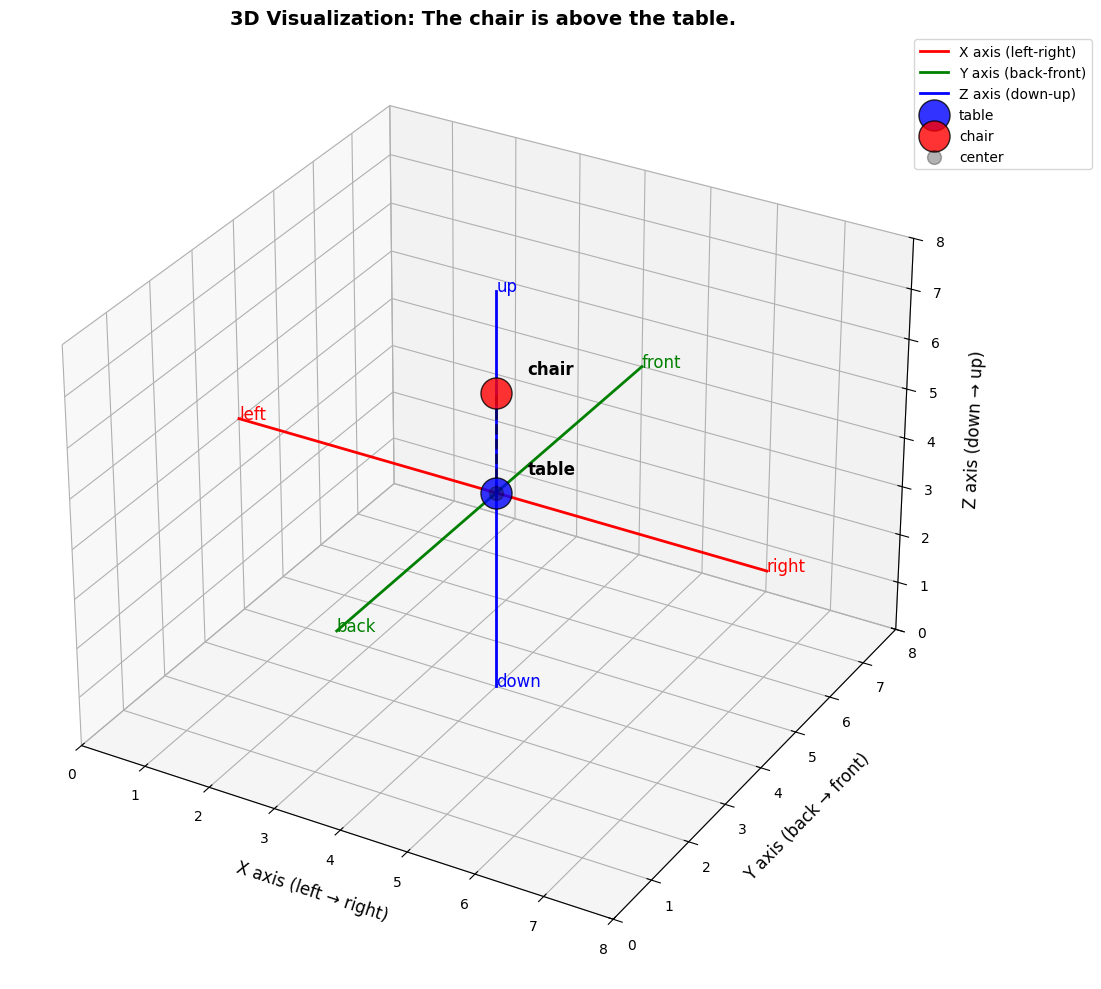

Object positions: {'table': (4, 4, 4), 'chair': (4, 4, 6)}
--------------------------------------------------
Test: The lamp is below the box.
  ✅ Test passed
  Object positions: {'lamp': (4, 4, 2), 'box': (4, 4, 4)}


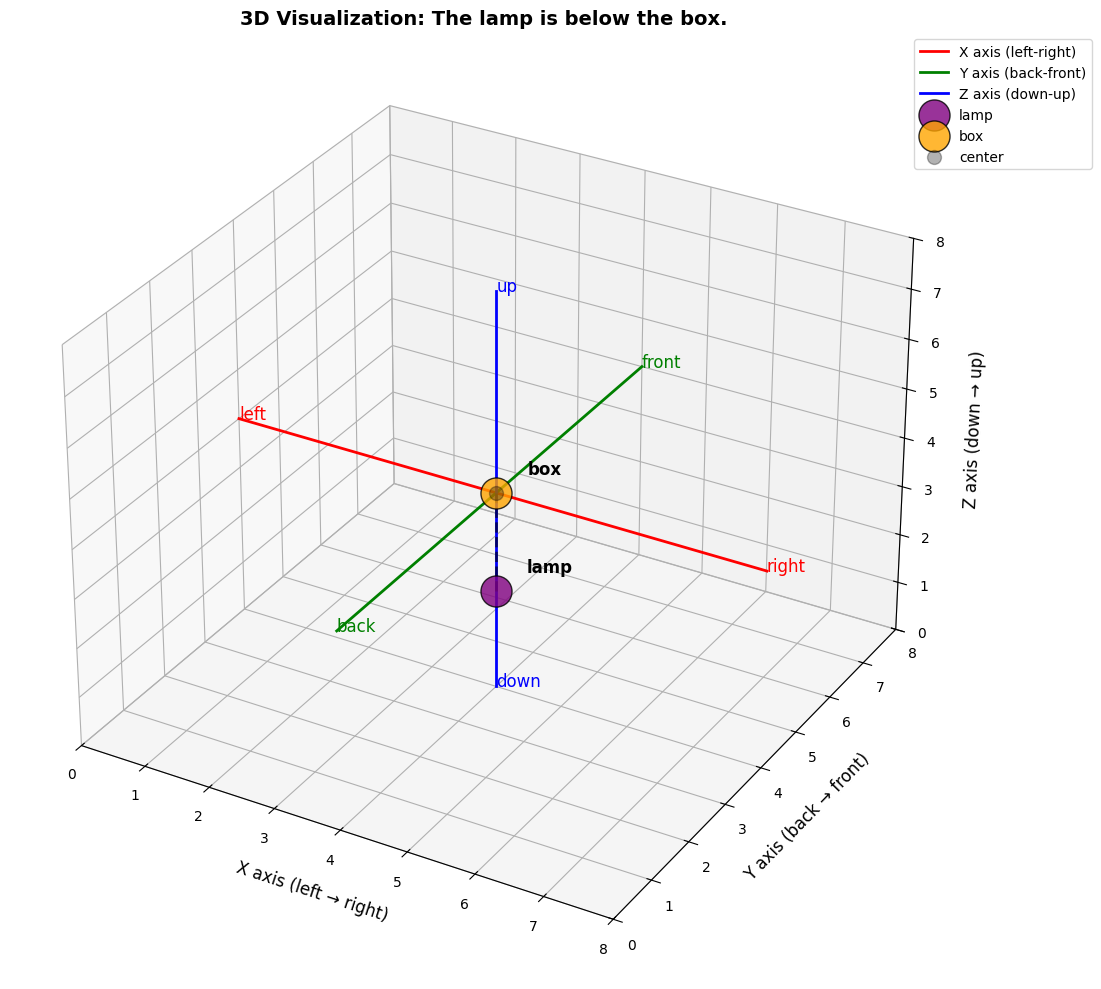

Object positions: {'lamp': (4, 4, 2), 'box': (4, 4, 4)}
--------------------------------------------------
Test: The car is to the right of the chair.
  ✅ Test passed
  Object positions: {'chair': (4, 4, 4), 'car': (6, 4, 4)}


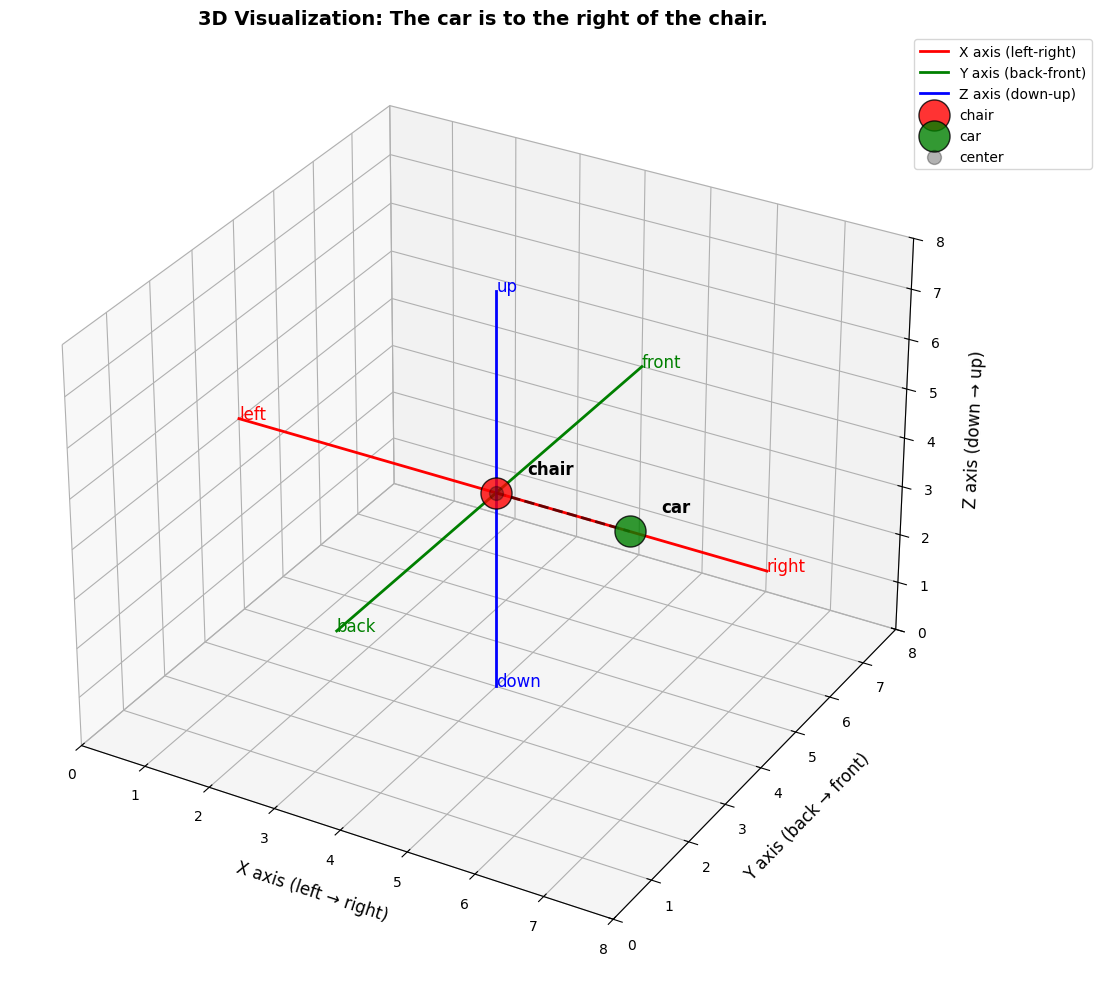

Object positions: {'chair': (4, 4, 4), 'car': (6, 4, 4)}
--------------------------------------------------
Test: The book is to the left of the vase.
  ✅ Test passed
  Object positions: {'book': (2, 4, 4), 'vase': (4, 4, 4)}


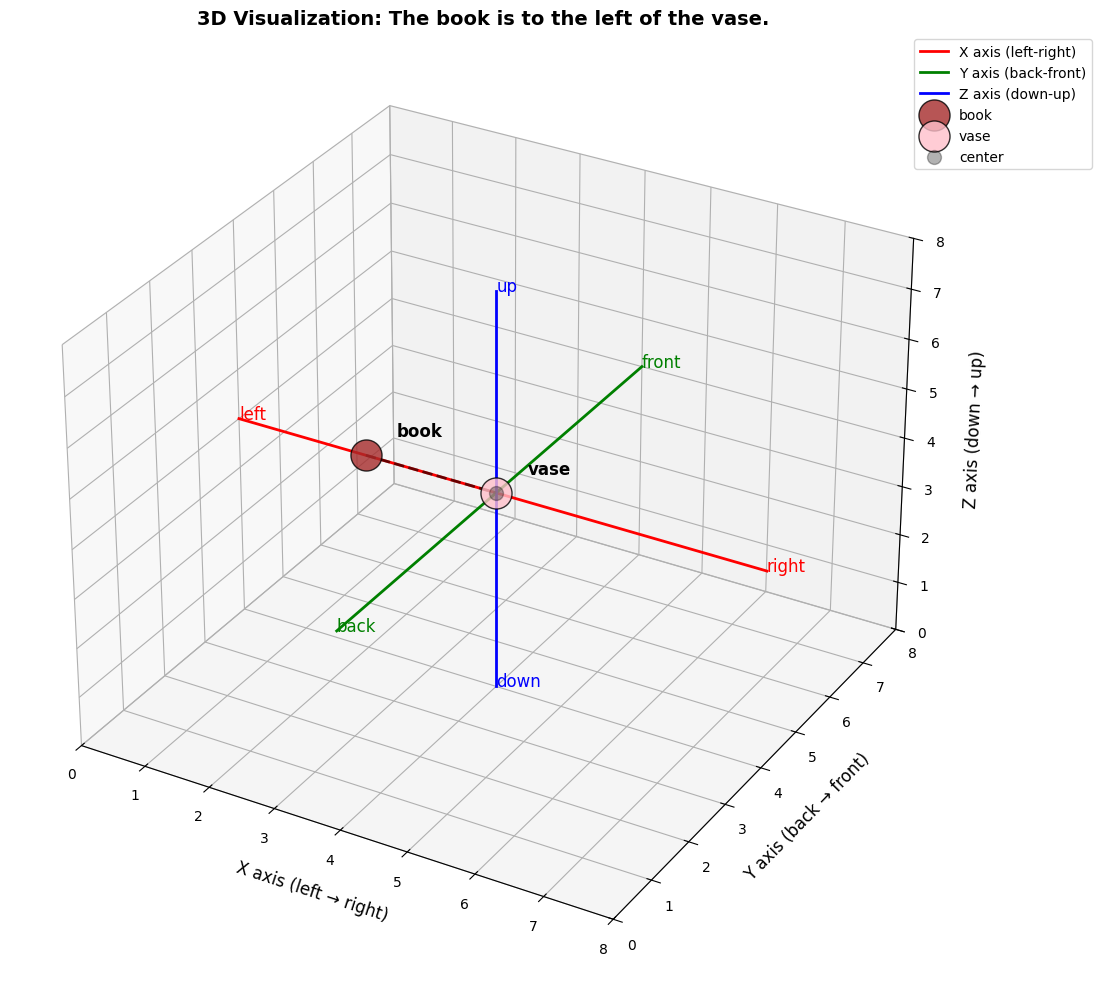

Object positions: {'book': (2, 4, 4), 'vase': (4, 4, 4)}
--------------------------------------------------

==== TESTING CATEGORY: Depth Relations ====

Test: The plant is behind the computer.
  ✅ Test passed
  Object positions: {'plant': (4, 2, 4), 'computer': (4, 4, 4)}


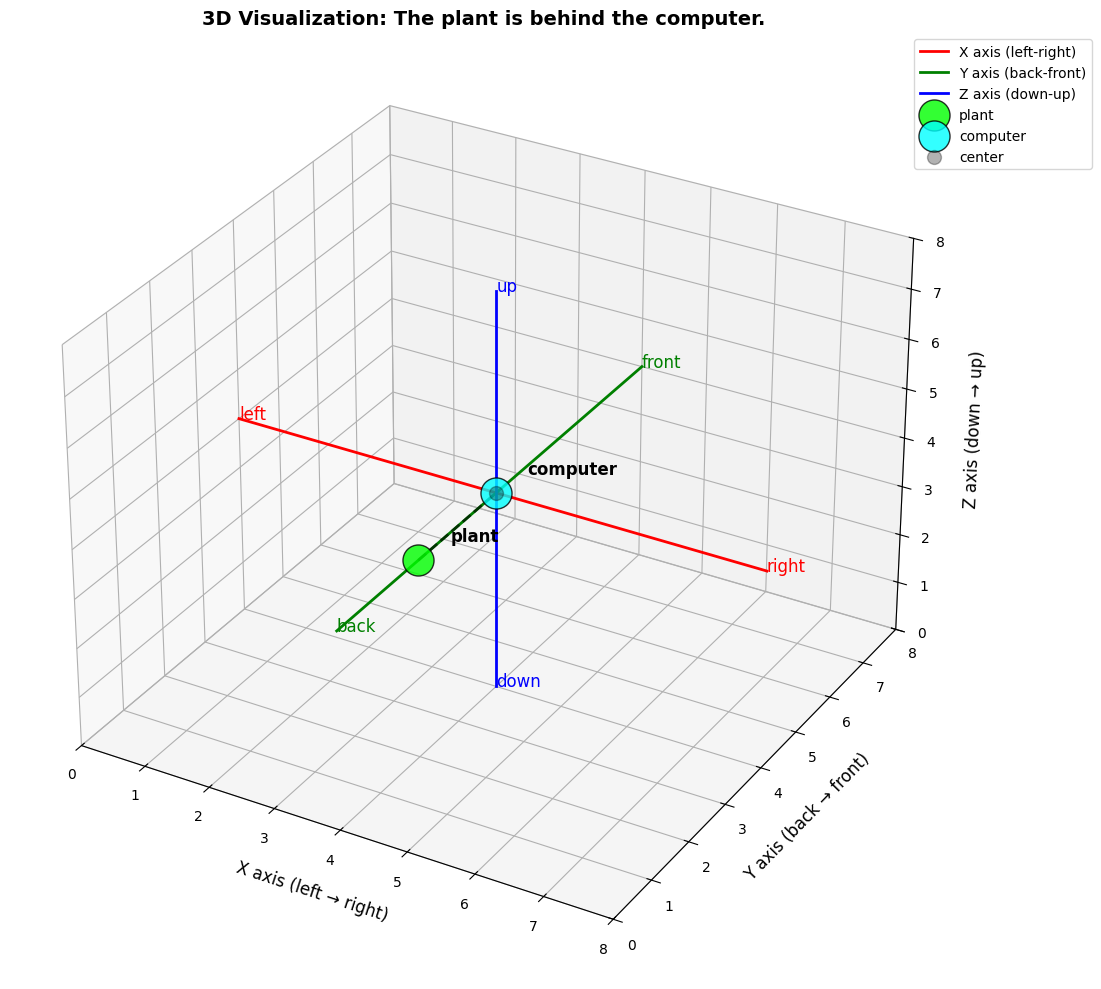

Object positions: {'plant': (4, 2, 4), 'computer': (4, 4, 4)}
--------------------------------------------------
Test: The phone is in front of the lamp.
  ✅ Test passed
  Object positions: {'lamp': (4, 4, 4), 'phone': (4, 6, 4)}


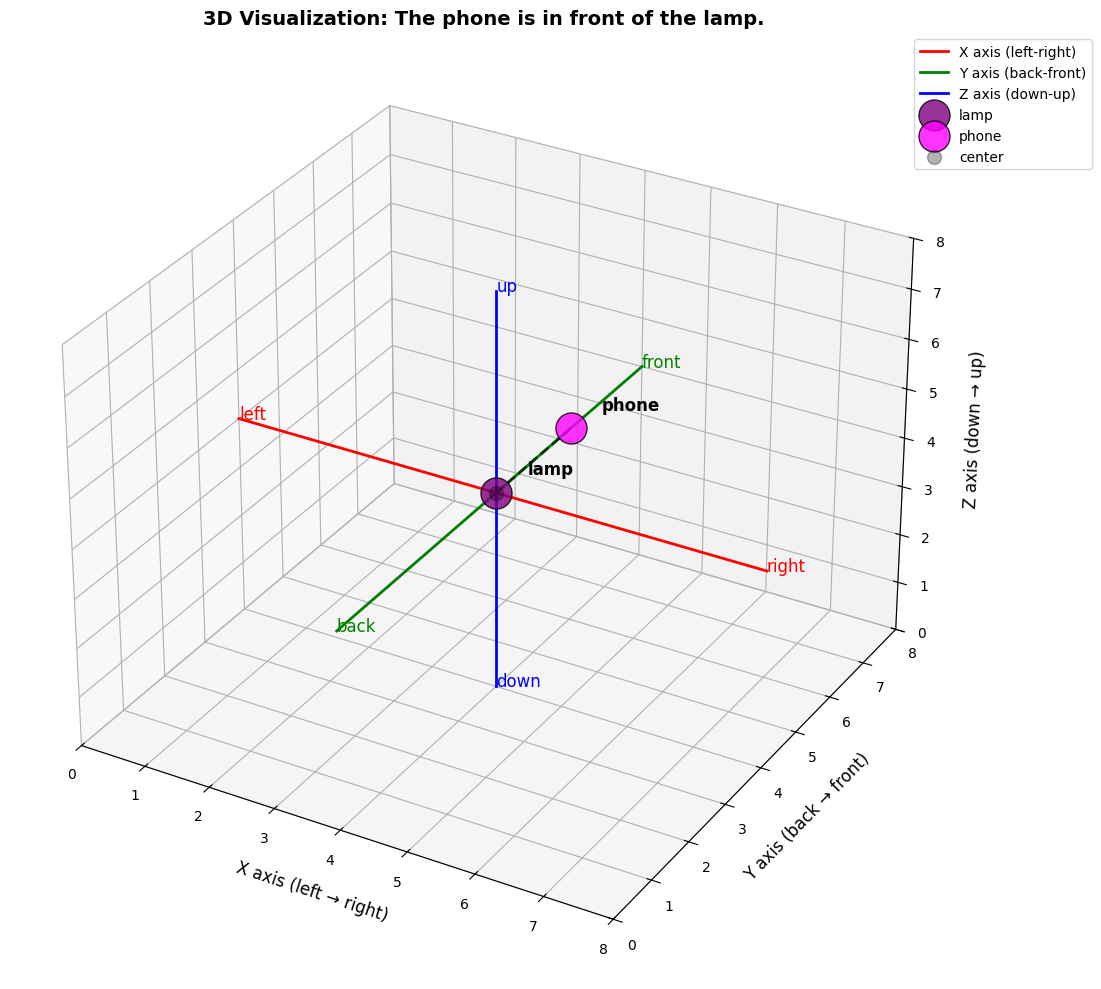

Object positions: {'lamp': (4, 4, 4), 'phone': (4, 6, 4)}
--------------------------------------------------

==== TESTING CATEGORY: Diagonal Relations ====

Test: The book is diagonally front-left of the vase.
  ✅ Test passed
  Object positions: {'vase': (4, 4, 4), 'book': (2, 6, 4)}


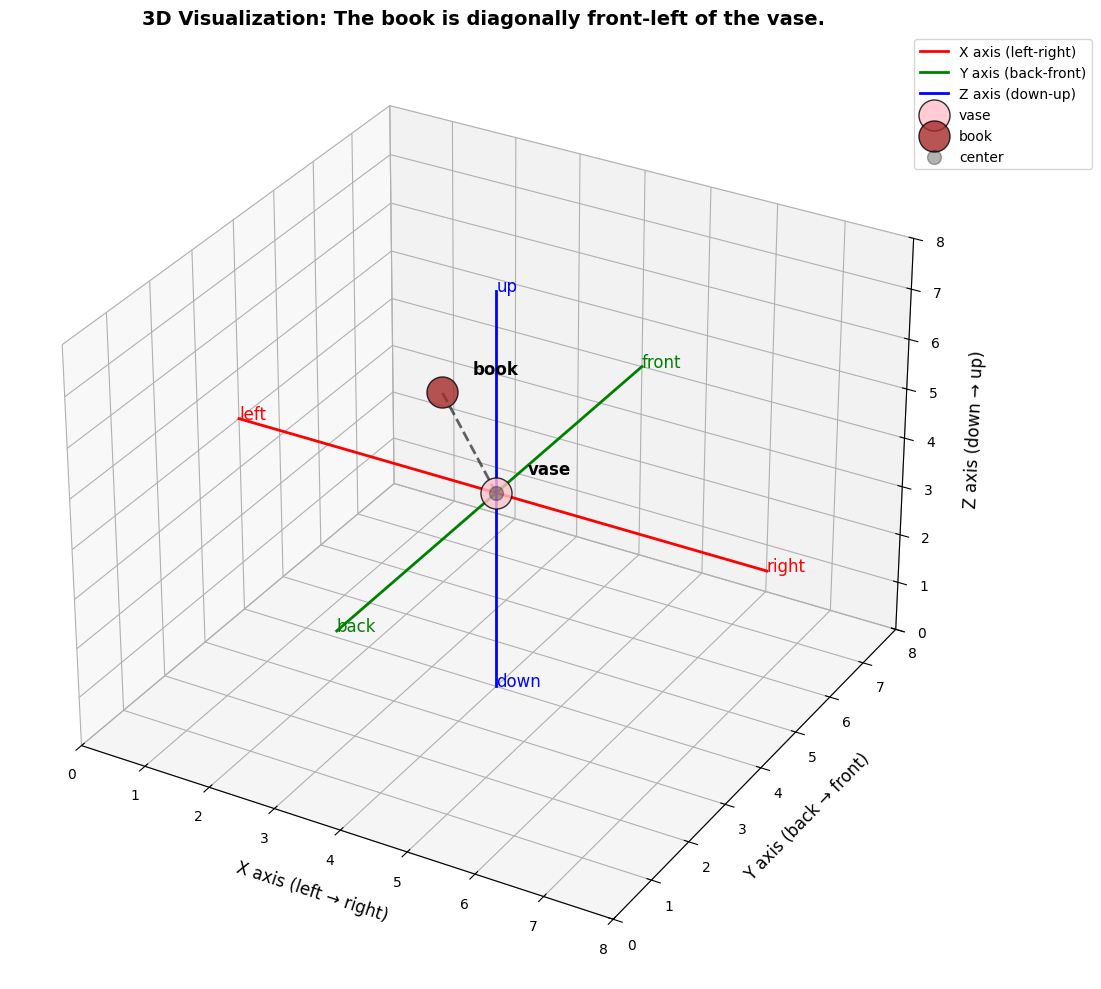

Object positions: {'vase': (4, 4, 4), 'book': (2, 6, 4)}
--------------------------------------------------
Test: The computer is diagonally back-right of the plant.
  ✅ Test passed
  Object positions: {'computer': (6, 2, 4), 'plant': (4, 4, 4)}


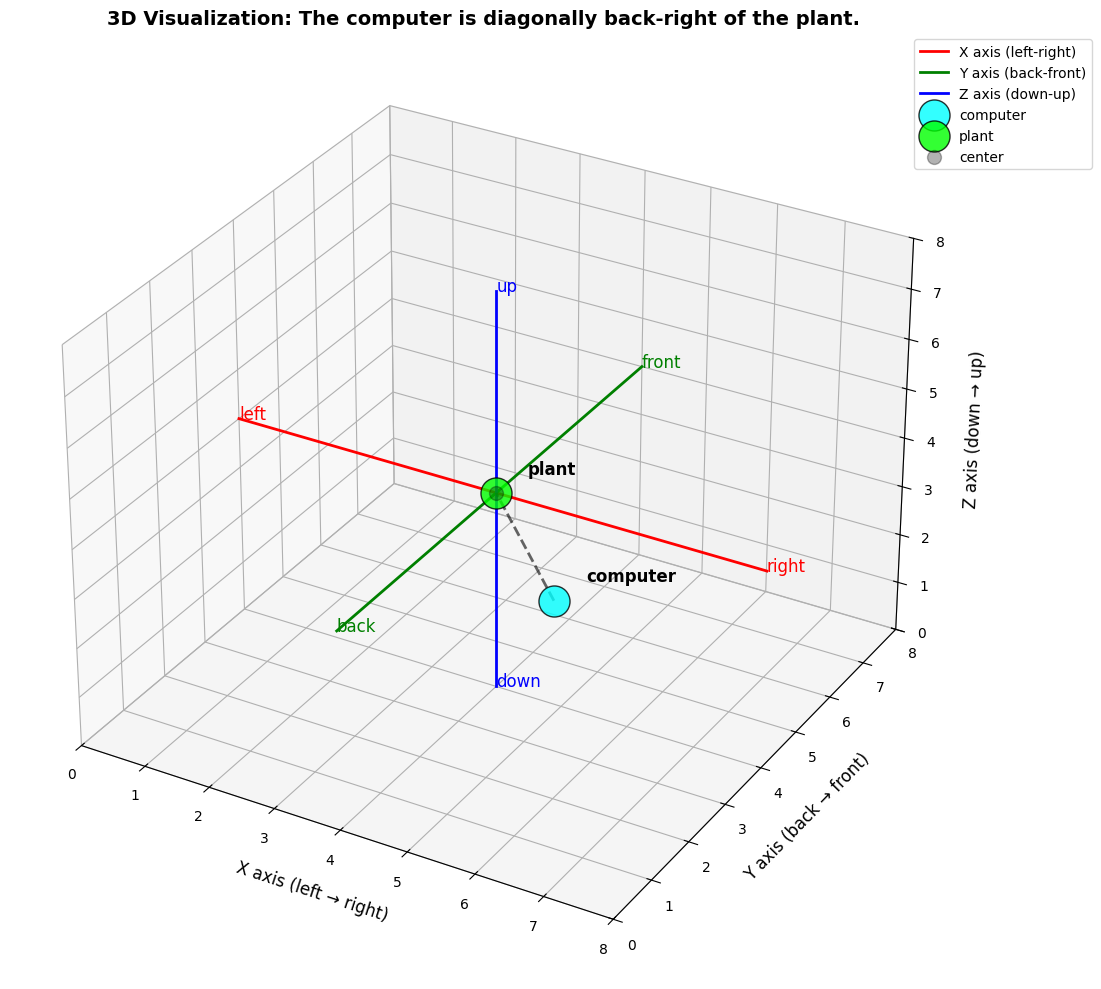

Object positions: {'computer': (6, 2, 4), 'plant': (4, 4, 4)}
--------------------------------------------------
Test: The lamp is diagonally front-right of the box.
  ✅ Test passed
  Object positions: {'box': (4, 4, 4), 'lamp': (6, 6, 4)}


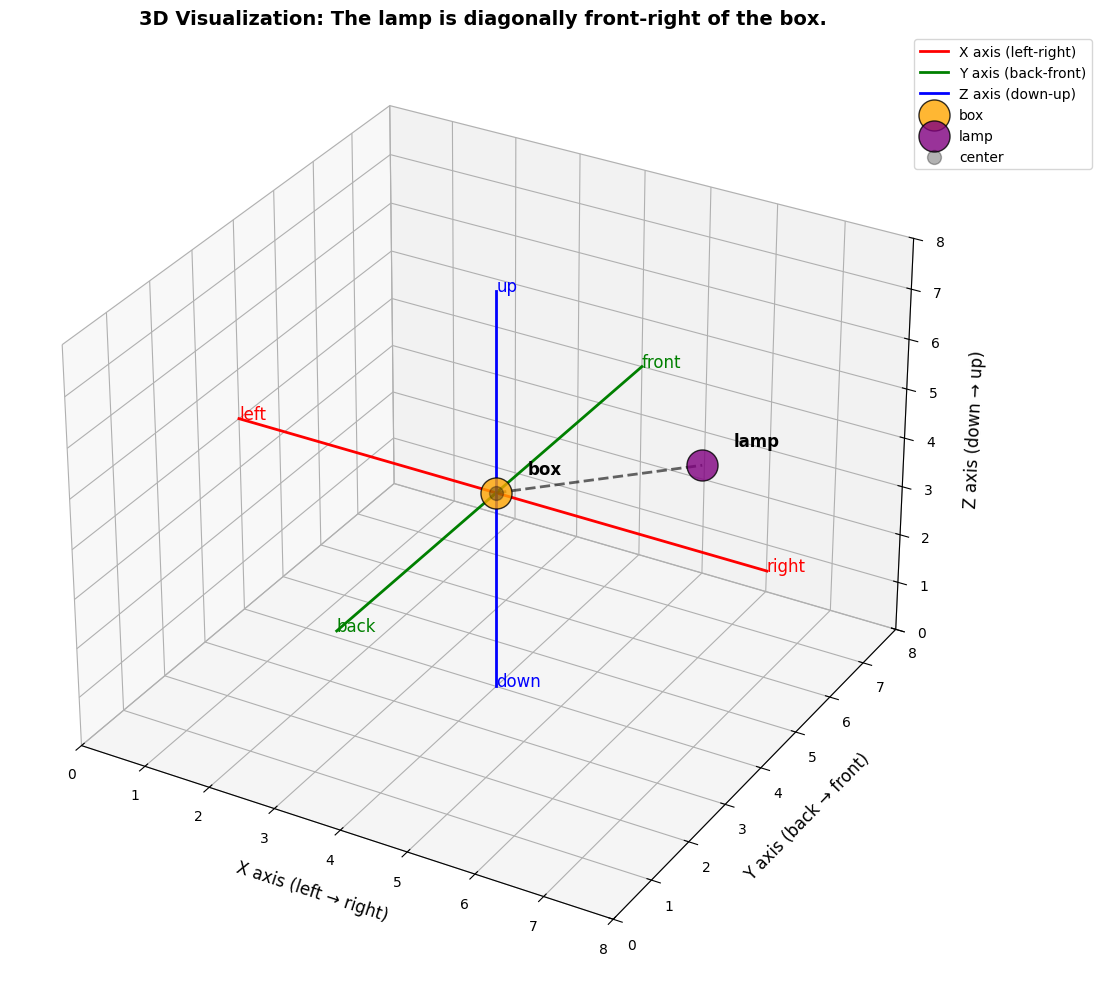

Object positions: {'box': (4, 4, 4), 'lamp': (6, 6, 4)}
--------------------------------------------------
Test: The chair is diagonally back-left of the table.
  ✅ Test passed
  Object positions: {'chair': (2, 2, 4), 'table': (4, 4, 4)}


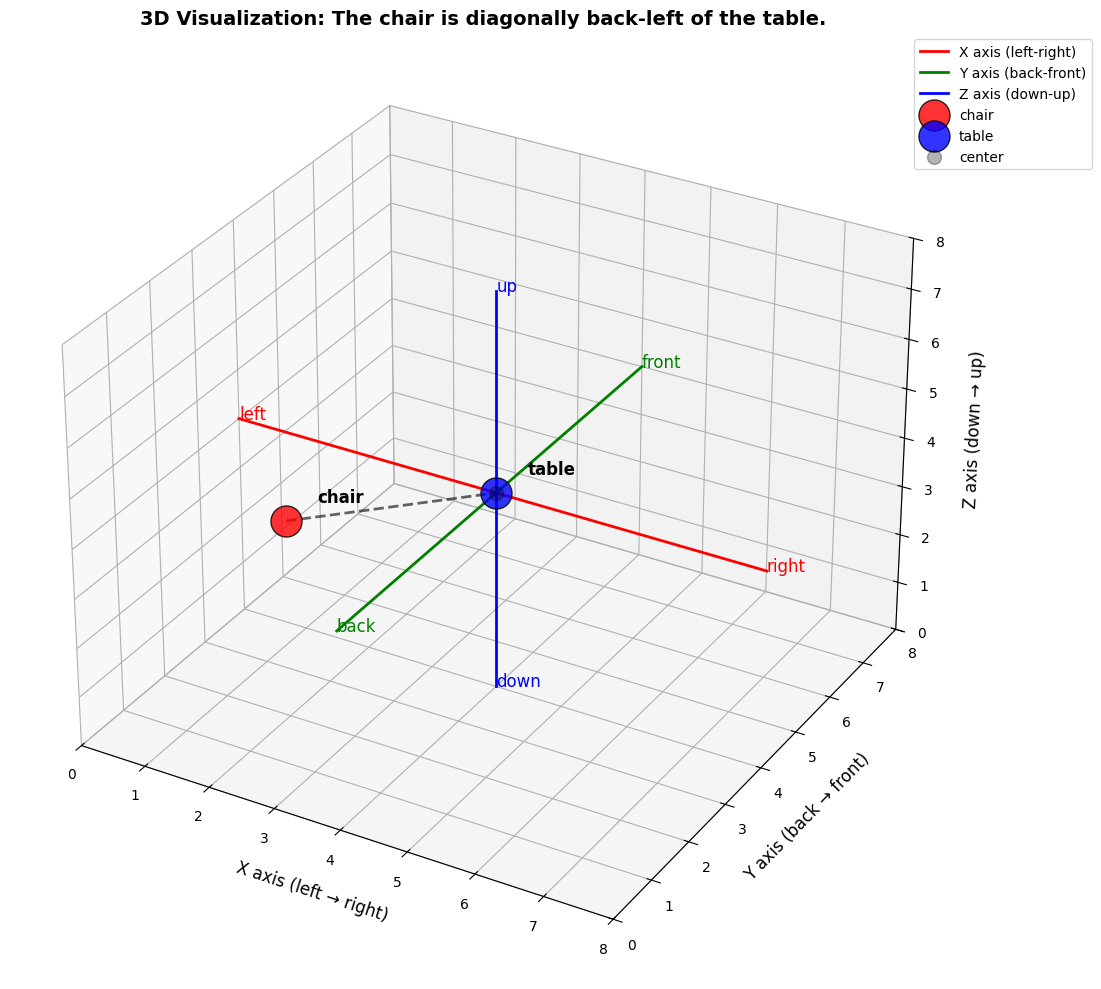

Object positions: {'chair': (2, 2, 4), 'table': (4, 4, 4)}
--------------------------------------------------
Test: The vase is to the left diagonally in front of the plant.
  ❌ Object 'vase' not found in grid
  Object positions: {'plant': (4, 4, 4)}


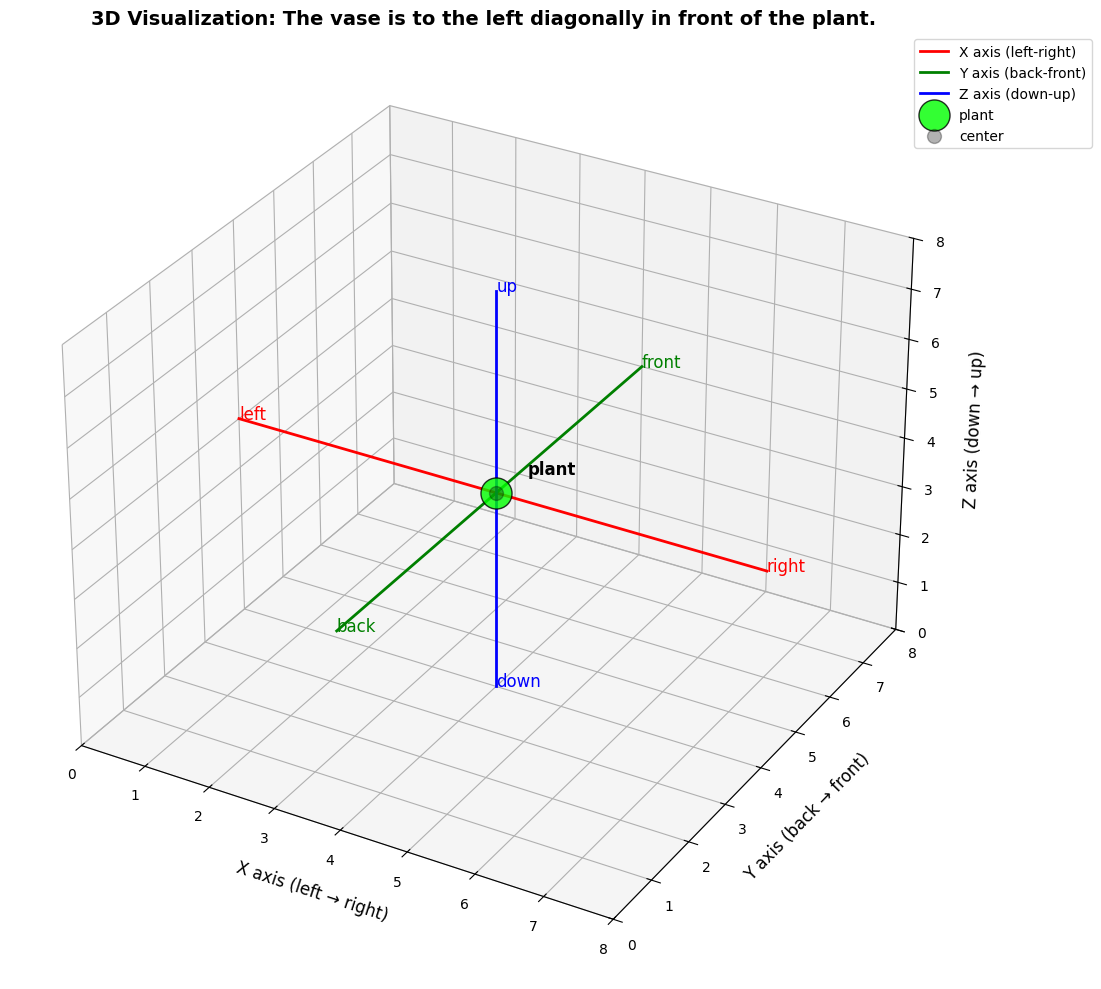

Object positions: {'plant': (4, 4, 4)}
--------------------------------------------------
Test: The car is diagonally to the right and behind the chair.
  ❌ Object 'car' not found in grid
  Object positions: {'chair': (4, 4, 4)}


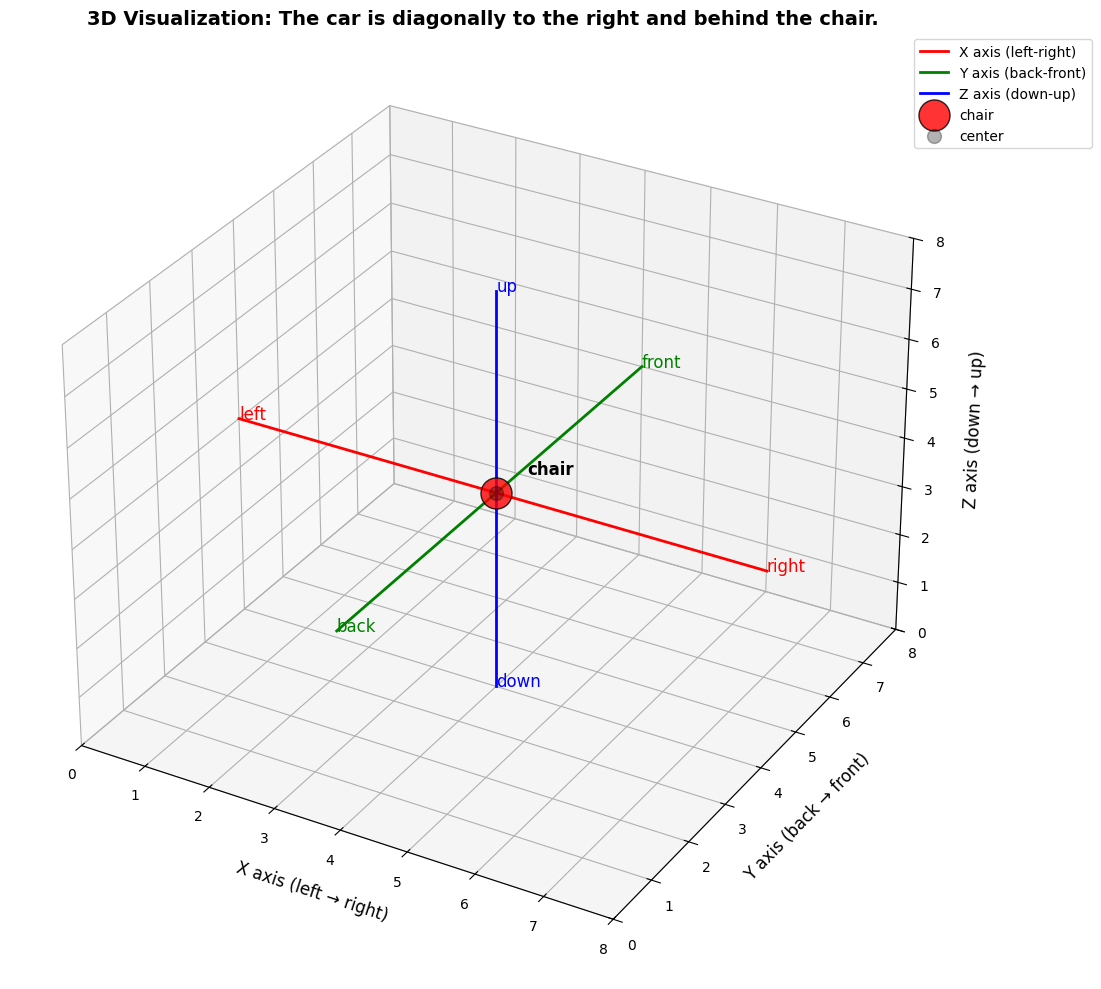

Object positions: {'chair': (4, 4, 4)}
--------------------------------------------------

==== TESTING CATEGORY: Compound Relations ====

Test: The chair is above and to the right of the table.
  ✅ Test passed
  Object positions: {'table': (4, 4, 4), 'chair': (6, 4, 6)}


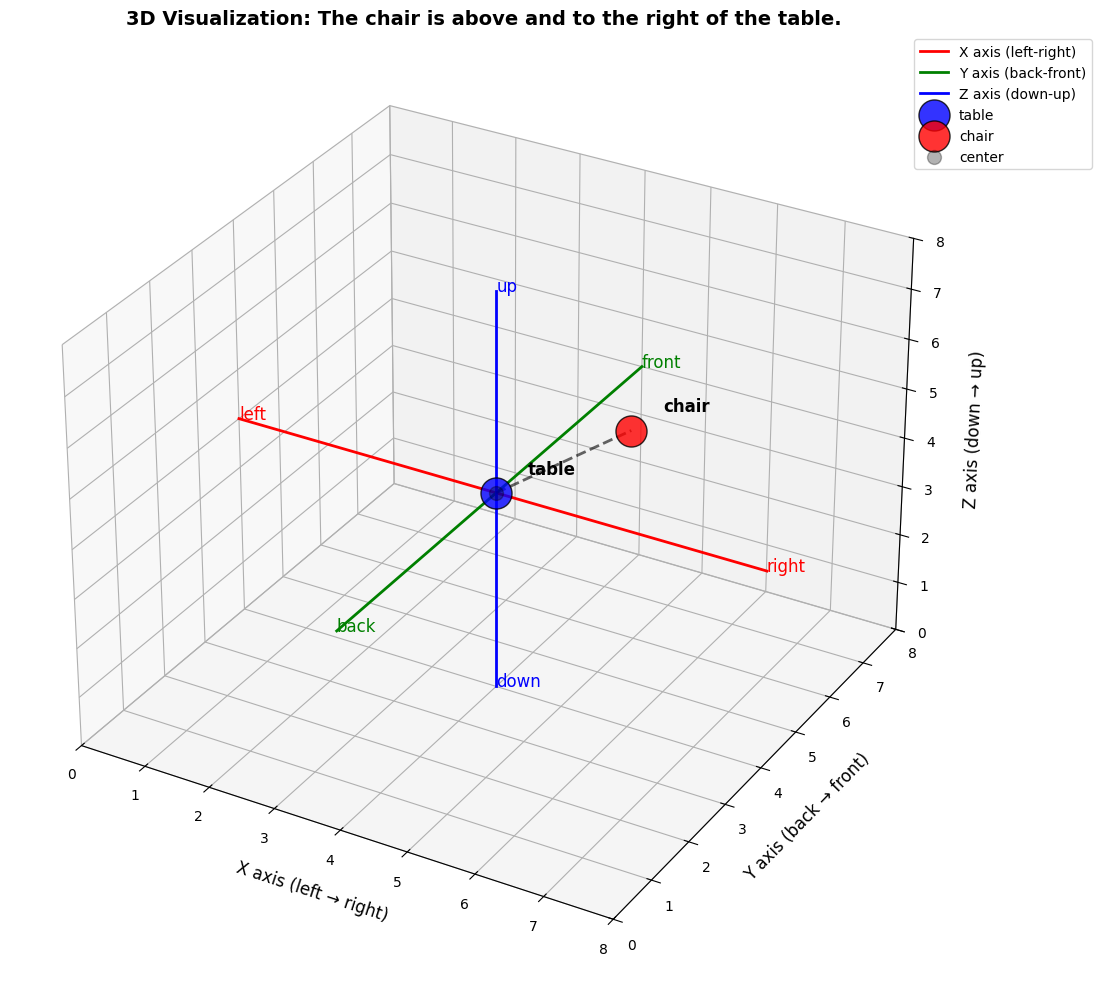

Object positions: {'table': (4, 4, 4), 'chair': (6, 4, 6)}
--------------------------------------------------
Test: The lamp is below and behind the box.
  ❌ Object 'lamp' not found in grid
  Object positions: {'box': (4, 4, 4)}


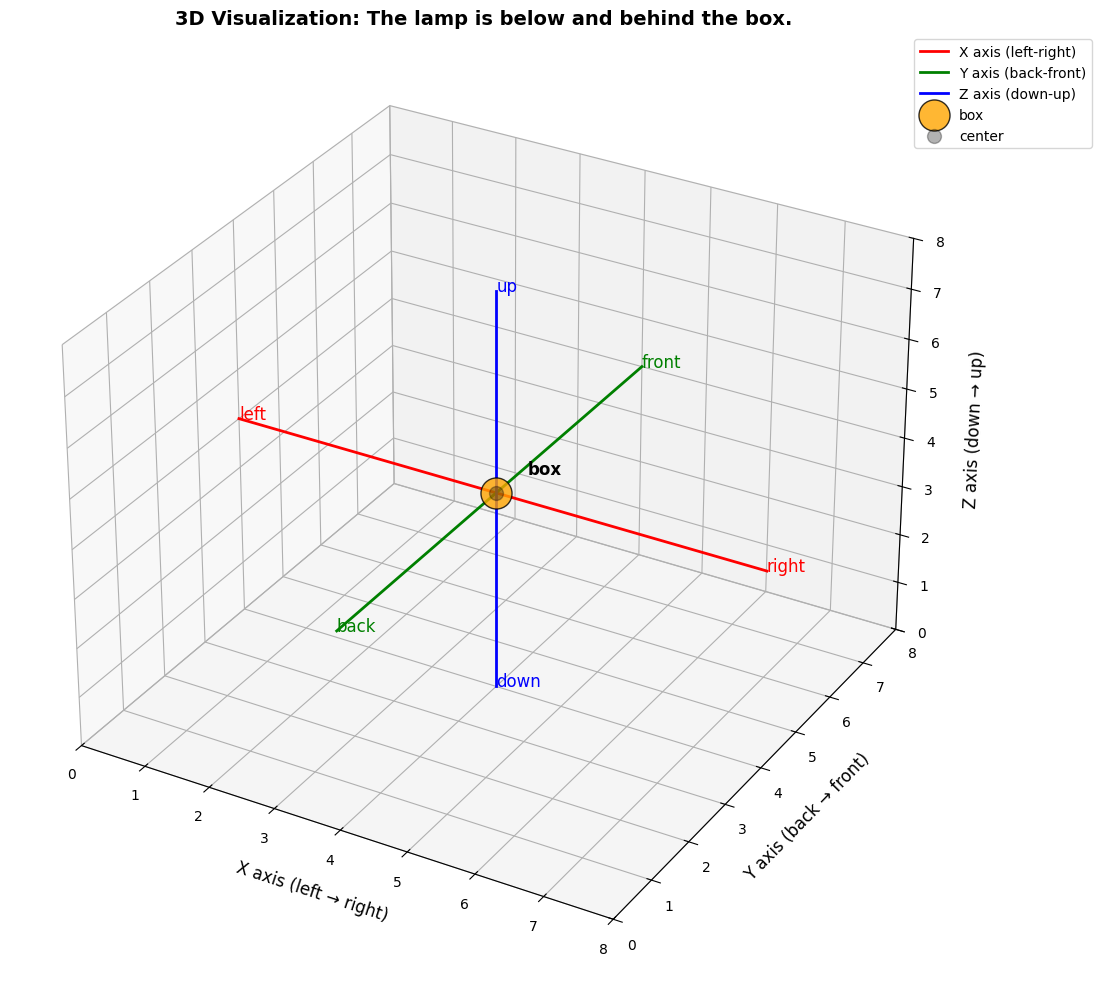

Object positions: {'box': (4, 4, 4)}
--------------------------------------------------
Test: The phone is above and in front of the box.
  ❌ Object 'phone' not found in grid
  Object positions: {'box': (4, 4, 4)}


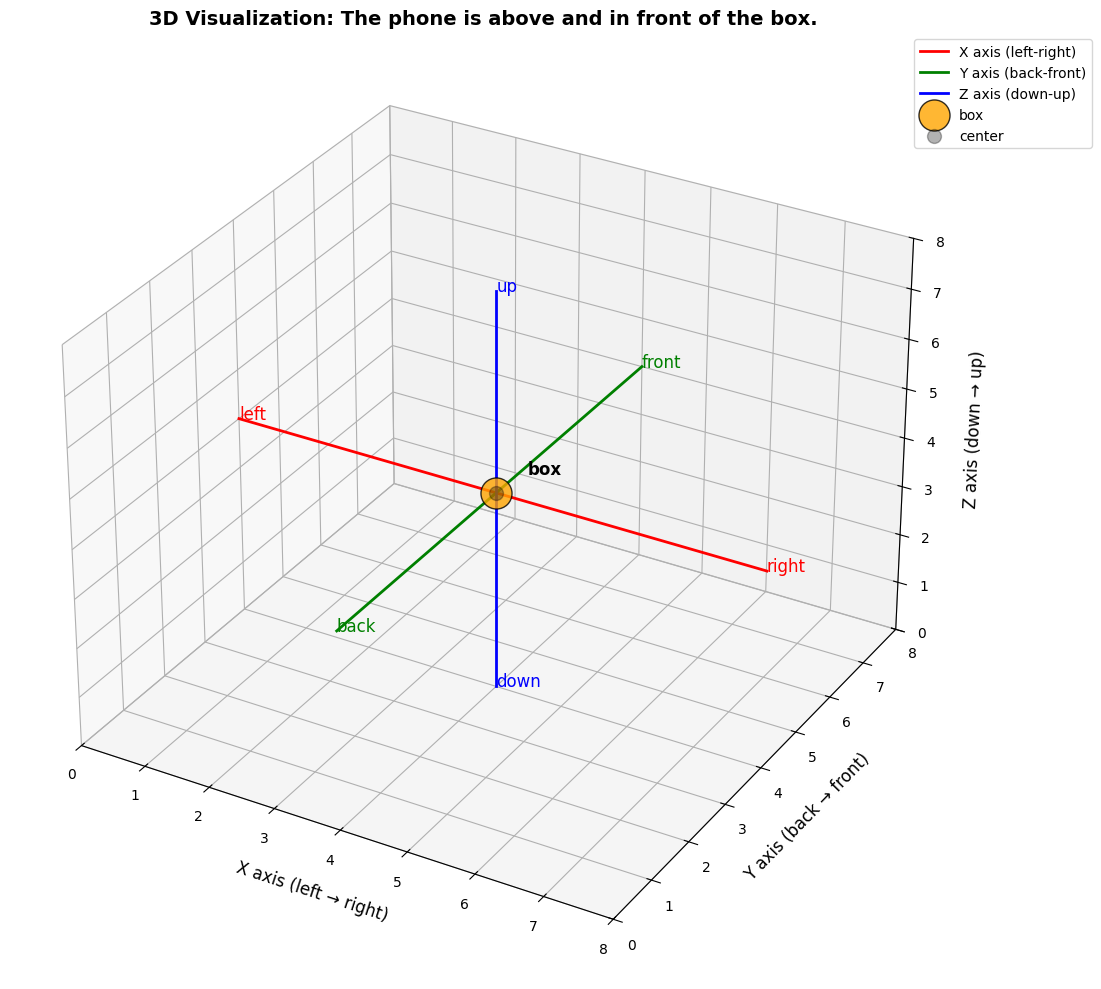

Object positions: {'box': (4, 4, 4)}
--------------------------------------------------
Test: The vase is below and to the left of the table.
  ✅ Test passed
  Object positions: {'vase': (2, 4, 2), 'table': (4, 4, 4)}


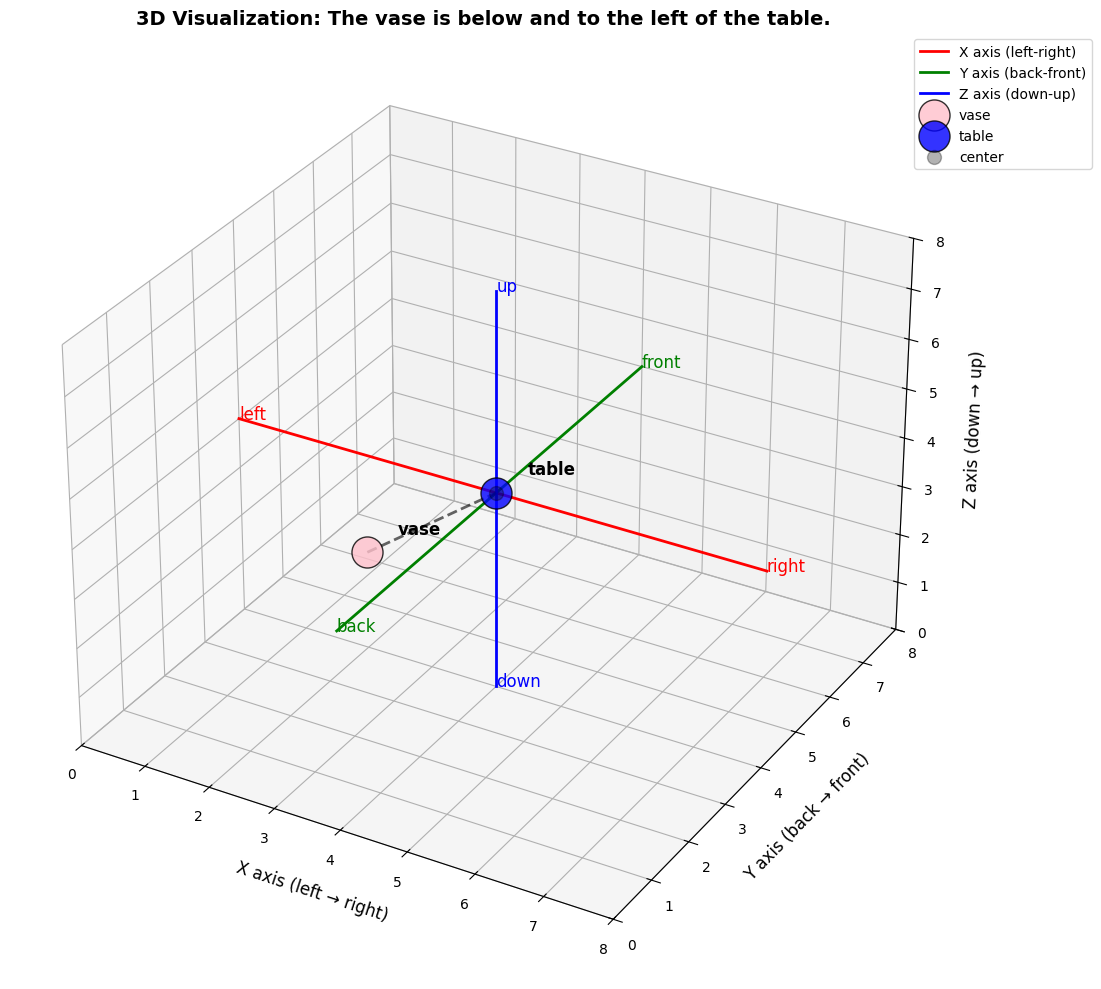

Object positions: {'vase': (2, 4, 2), 'table': (4, 4, 4)}
--------------------------------------------------

==== TEST SUMMARY ====
Basic Orthogonal: 4/4 passed (100.0%)
Depth Relations: 2/2 passed (100.0%)
Diagonal Relations: 4/6 passed (66.7%)
Compound Relations: 2/4 passed (50.0%)

Overall: 12/16 passed (75.0%)

==== DETAILED FAILURES ====
Category: Diagonal Relations
Test: The vase is to the left diagonally in front of the plant.
Found: {'plant': (4, 4, 4)}
Expected objects: ['vase', 'plant']
------------------------------
Category: Diagonal Relations
Test: The car is diagonally to the right and behind the chair.
Found: {'chair': (4, 4, 4)}
Expected objects: ['chair', 'car']
------------------------------
Category: Compound Relations
Test: The lamp is below and behind the box.
Found: {'box': (4, 4, 4)}
Expected objects: ['lamp', 'box']
------------------------------
Category: Compound Relations
Test: The phone is above and in front of the box.
Found: {'box': (4, 4, 4)}
Expected ob

In [ ]:
if __name__ == "__main__":
    # Initialize the experiment runner
    runner = SpatialExperimentRunner(auth_token=hf_token)

    # Run with existing data and model
    probe, data = runner.run(extract_new=False, train_new=False)

## CausalIntervention

### basic steering

In [ ]:

def run_causal_intervention_experiment(runner, probe, scale_factors=[1.0, 10.0]):
    """
    Run a causal intervention experiment using the trained probe to extract steering vectors.

    Args:
        runner: The SpatialExperimentRunner instance
        probe: The trained LinearSpatialProbe model
        scale_factors: List of scaling factors to test for interventions
    """
    print("\n=== Starting Causal Intervention Experiment ===\n")

    # Initialize components
    lm_handler = runner.lm_handler
    model = lm_handler.model
    tokenizer = lm_handler.tokenizer

    # 1. Extract spatial vectors from probe
    vector_extractor = VectorExtractor(probe)
    spatial_vectors, d_model = vector_extractor.extract_spatial_directions()

    # 2. Compute PCA subspace
    pca, projected_vectors = vector_extractor.compute_pca_subspace(spatial_vectors)

    # 3. Generate steering vectors
    steering_vectors = vector_extractor.generate_steering_vectors(pca, spatial_vectors)

    # 4. Run the intervention experiment
    intervention = CausalIntervention(model, tokenizer)

    # Create test pairs
    test_pairs = intervention.create_test_pairs()

    # Run the steering experiment
    results = intervention.run_steering_experiment(
        steering_vectors=steering_vectors,
        layer_idx=24,  # You may need to adjust this based on your model
        scale_factors=scale_factors
    )

    print("\n=== Causal Intervention Experiment Completed ===\n")
    return results, steering_vectors


In [ ]:
if __name__ == "__main__":
    # # Initialize the experiment runner
    # runner = SpatialExperimentRunner(auth_token=hf_token)

    # # Run with existing data and model
    # probe, data = runner.run(extract_new=False, train_new=False)

    # Run causal intervention experiment
    if probe is not None:
        results, steering_vectors = run_causal_intervention_experiment(runner, probe)

        # Optional: Save the steering vectors for future use
        torch.save(steering_vectors, "spatial_steering_vectors.pt")

        # You can also test with custom examples
        print("\n=== Testing Steering with Custom Examples ===\n")

        # Create intervention object
        model = runner.lm_handler.model
        tokenizer = runner.lm_handler.tokenizer
        intervention = CausalIntervention(model, tokenizer)

        # Test a specific steering direction
        test_sentence = "The chair is to the left of the table. Where is the chair relative to the table?"

        # Create hook for the horizontal direction
        steering_vector = steering_vectors["horizontal"]
        hook_fn = intervention.create_steering_hook(steering_vector, layer_idx=24, scale_factor=50.0)

        # Register hook
        hook_handle = model.model.layers[24].register_forward_hook(hook_fn)

        # Generate steered response
        steered_response = intervention.generate_response(test_sentence)
        print(f"Original sentence: {test_sentence}")
        print(f"Steered response (horizontal): {steered_response}")

        # Remove hook
        hook_handle.remove()


=== Starting Causal Intervention Experiment ===

Extracting spatial direction vectors...
Computing PCA subspace...
PCA explained variance: [0.33752316 0.2484335  0.1738138 ]
Generating improved steering vectors with semantic differences and orthogonalization...

Verifying orthogonality of steering vectors:
  horizontal vs horizontal: 1.0000
  horizontal vs vertical: 0.0000
  horizontal vs depth: 0.0000
  vertical vs horizontal: 0.0000
  vertical vs vertical: 1.0000
  vertical vs depth: -0.0000
  depth vs horizontal: 0.0000
  depth vs vertical: -0.0000
  depth vs depth: 1.0000

Verifying semantic alignment of steering vectors:

horizontal steering vector alignment:
  Similarity to right: 0.5190
  Similarity to left: -0.7443
  Similarity to right-left difference: 0.9889

vertical steering vector alignment:
  Similarity to above: 0.5511
  Similarity to below: -0.7018
  Similarity to above-below difference: 0.9619

depth steering vector alignment:
  Similarity to in_front: 0.0690
  Simila

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Original: The chair is to the left of the table.
Question: Where is the chair relative to the table?
Steered Response: left
Expected: right
Success: False
--------------------------------------------------
Original: The book is to the right of the vase.
Question: Where is the book relative to the vase?
Steered Response: left
Expected: left
Success: True
--------------------------------------------------
Original: The lamp is above the box.
Question: Where is the lamp relative to the box?
Steered Response: above
Expected: below
Success: False
--------------------------------------------------
Original: The phone is below the computer.
Question: Where is the phone relative to the computer?
Steered Response: above
Expected: above
Success: True
--------------------------------------------------
Original: The car is in front of the plant.
Question: Where is the car relative to the plant?
Steered Response: in front
Expected: behind
Success: False
---------------------------------------------

  0%|          | 0/6 [00:00<?, ?it/s]

Original: The chair is to the left of the table.
Question: Where is the chair relative to the table?
Steered Response: left
Expected: right
Success: False
--------------------------------------------------
Original: The book is to the right of the vase.
Question: Where is the book relative to the vase?
Steered Response: left
Expected: left
Success: True
--------------------------------------------------
Original: The lamp is above the box.
Question: Where is the lamp relative to the box?
Steered Response: above
Expected: below
Success: False
--------------------------------------------------
Original: The phone is below the computer.
Question: Where is the phone relative to the computer?
Steered Response: above
Expected: above
Success: True
--------------------------------------------------
Original: The car is in front of the plant.
Question: Where is the car relative to the plant?
Steered Response: in front
Expected: behind
Success: False
---------------------------------------------

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Original sentence: The chair is to the left of the table. Where is the chair relative to the table?
Steered response (horizontal): left


### optimal steering

#### steering function

In [ ]:

def generate_steering_vectors(probe, use_cache=False, cache_path="spatial_steering_vectors.pt", force_new=True):
    """
    Generate enhanced steering vectors for spatial relationships with better organization and flexibility.

    Args:
        probe (LinearSpatialProbe): Trained spatial probe
        use_cache (bool): Whether to use cached vectors if available
        cache_path (str): Path to save/load cached vectors
        force_new (bool): Force regeneration of vectors even if cache exists

    Returns:
        dict: Enhanced steering vectors with metadata
    """
    # Try to load cached vectors if requested
    if use_cache and os.path.exists(cache_path) and not force_new:
        try:
            print(f"Loading cached steering vectors from {cache_path}")
            cached_vectors = torch.load(cache_path)

            # Verify the cached file has the expected structure
            required_keys = ["metadata", "basic", "optimized", "experimental", "raw"]

            if all(key in cached_vectors for key in required_keys):
                # Move vectors to GPU if they're on CPU
                for category in ["basic", "optimized", "experimental"]:
                    if isinstance(cached_vectors[category], dict):
                        for k, v in cached_vectors[category].items():
                            if isinstance(v, dict) and "vector" in v:
                                cached_vectors[category][k]["vector"] = v["vector"].cuda()
                            elif isinstance(v, torch.Tensor):
                                cached_vectors[category][k] = v.cuda()

                print("Successfully loaded cached vectors")
                return cached_vectors
            else:
                print(f"Cached file has invalid format. Required keys: {required_keys}")
                print(f"Found keys: {list(cached_vectors.keys())}")
                print("Regenerating vectors...")
        except Exception as e:
            print(f"Error loading cached vectors: {e}")
            print("Regenerating vectors...")

    print("Generating enhanced steering vectors...")

    # Extract spatial directions using VectorExtractor
    vector_extractor = VectorExtractor(probe)
    spatial_vectors, d_model = vector_extractor.extract_spatial_directions()

    # Compute PCA subspace
    pca, projected_vectors = vector_extractor.compute_pca_subspace(spatial_vectors)

    # PCA components matrix (shape: [n_components, d_model])
    components = pca.components_

    # Function to project a vector into PCA space and back
    def project_through_pca(vector):
        """Project a vector into PCA space and then back to original space."""
        # Convert to numpy for PCA
        if isinstance(vector, torch.Tensor):
            vector_np = vector.cpu().numpy()
        else:
            vector_np = vector

        # Project into PCA space
        pca_coords = pca.transform(vector_np.reshape(1, -1))[0]

        # Project back to original space
        projected_back = np.dot(pca_coords, components)

        # Convert back to tensor
        return torch.tensor(projected_back, dtype=torch.float32).cuda()

    # Create basic steering vectors (original method)
    basic_steering = {
        "horizontal": torch.tensor(np.dot([1.0, 0, 0], pca.components_), dtype=torch.float32).cuda(),
        "vertical": torch.tensor(np.dot([0, 0, 1.0], pca.components_), dtype=torch.float32).cuda(),
        "depth": torch.tensor(np.dot([0, 1.0, 0], pca.components_), dtype=torch.float32).cuda(),
    }

    # Create raw difference vectors
    raw_diff_vectors = {
        "right_left": spatial_vectors["right"] - spatial_vectors["left"],
        "above_below": spatial_vectors["above"] - spatial_vectors["below"],
        "front_behind": spatial_vectors["in_front"] - spatial_vectors["behind"]
    }

    # Project these raw difference vectors through PCA
    pca_diff_vectors = {
        "right_left": project_through_pca(raw_diff_vectors["right_left"]),
        "above_below": project_through_pca(raw_diff_vectors["above_below"]),
        "front_behind": project_through_pca(raw_diff_vectors["front_behind"])
    }

    # Create optimized vectors for specific relations based on our experiments
    optimized_steering = {
        # Direct PC0 component for right
        "right": {
            "vector": torch.tensor(np.dot([1.0, 0, 0], pca.components_), dtype=torch.float32).cuda(),
            "scale": 40,
            "success_rate": 1.0,
            "description": "First PCA component controlling horizontal dimension"
        },

        # Depth difference for below (discovered cross-dimensional effect)
        "below": {
            "vector": (spatial_vectors["in_front"] - spatial_vectors["behind"]).cuda(),
            "scale": 40,
            "success_rate": 1.0,
            "description": "Depth difference vector that affects vertical dimension"
        },

        # Combined vector for behind
        "behind": {
            "vector": (spatial_vectors["behind"] + 0.3*spatial_vectors["left"]).cuda(),
            "scale": 30,
            "success_rate": 1.0,
            "description": "Combined behind + small left component"
        },

        # Front/In front - using projected difference vector
        "front": {
            "vector": pca_diff_vectors["front_behind"],
            "scale": 40,
            "success_rate": 0.9,
            "description": "PCA-projected front-behind difference vector"
        },

        # Add vectors for other directions using the same pattern
        "left": {
            "vector": -1.0 * torch.tensor(np.dot([1.0, 0, 0], pca.components_), dtype=torch.float32).cuda(),
            "scale": 40,
            "success_rate": 0.8,  # Estimate
            "description": "Negative of the right vector (first PCA component)"
        },

        "above": {
            "vector": torch.tensor(np.dot([0, 0, 1.0], pca.components_), dtype=torch.float32).cuda(),
            "scale": 10,
            "success_rate": 0.8,  # Estimate
            "description": "Negative of the below vector (inverted depth difference)"
        }
    }


    # Compile everything into one comprehensive dictionary
    steering_vectors = {
        "metadata": {
            "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
            "pca_variance": pca.explained_variance_ratio_.tolist(),
            "d_model": d_model,
            "spatial_directions": list(spatial_vectors.keys())
        },
        "basic": basic_steering,
        "optimized": optimized_steering,
        "raw": {
            "spatial_vectors": {k: v.cpu() for k, v in spatial_vectors.items()},
            "pca_components": pca.components_
        }
    }

    # Cache the vectors if requested
    if use_cache:
        try:
            # Save CPU versions of tensors to make the file portable
            save_dict = copy.deepcopy(steering_vectors)

            # Move tensors to CPU for storage
            for category in ["basic", "optimized", "experimental"]:
                if isinstance(save_dict[category], dict):
                    for k, v in save_dict[category].items():
                        if isinstance(v, dict) and "vector" in v:
                            save_dict[category][k]["vector"] = v["vector"].cpu()
                        elif isinstance(v, torch.Tensor):
                            save_dict[category][k] = v.cpu()

            torch.save(save_dict, cache_path)
            print(f"Steering vectors cached to {cache_path}")
        except Exception as e:
            print(f"Error caching vectors: {e}")

    return steering_vectors


def create_spatial_steering_toolkit(model, tokenizer, steering_vectors):
    """
    Create a comprehensive toolkit for applying spatial steering in various ways.

    Args:
        model: Language model
        tokenizer: Model tokenizer
        steering_vectors: Output from generate_steering_vectors

    Returns:
        dict: Dictionary of steering functions
    """
    # Verify the steering_vectors structure
    required_keys = ["optimized", "basic"]
    missing_keys = [key for key in required_keys if key not in steering_vectors]

    if missing_keys:
        raise ValueError(f"steering_vectors missing required keys: {missing_keys}")

    # Create intervention object
    intervention = CausalIntervention(model, tokenizer)

    def steer_to_relation(sentence, target_relation, layer_idx=24, custom_scale=None):
        """
        Steer a sentence to produce a specific spatial relation.

        Args:
            sentence: Input sentence
            target_relation: Target relation (e.g., "right", "below", "behind")
            layer_idx: Model layer to apply steering
            custom_scale: Override default scale if provided

        Returns:
            dict: Results including original and steered responses
        """
        # Check if the relation is supported
        if target_relation not in steering_vectors["optimized"]:
            supported = list(steering_vectors["optimized"].keys())
            print(f"Warning: Relation '{target_relation}' not in optimized vectors.")
            print(f"Supported relations: {supported}")

            # Check if it's in experimental
            if target_relation in steering_vectors["experimental"]:
                print(f"Using experimental vector for '{target_relation}'")
                config = steering_vectors["experimental"][target_relation]
            else:
                raise ValueError(f"Unsupported relation: {target_relation}")
        else:
            config = steering_vectors["optimized"][target_relation]

        # Get original response
        original_response = intervention.generate_response(sentence)

        # Apply steering
        vector = config["vector"]
        if not vector.device.type == "cuda":
            vector = vector.cuda()  # Ensure vector is on GPU

        scale = custom_scale if custom_scale is not None else config["scale"]

        hook_fn = intervention.create_steering_hook(vector, layer_idx=layer_idx, scale_factor=scale)
        hook_handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)

        # Generate steered response
        steered_response = intervention.generate_response(sentence)

        # Remove hook
        hook_handle.remove()

        return {
            "original_sentence": sentence,
            "original_response": original_response,
            "steered_response": steered_response,
            "target_relation": target_relation,
            "success": steered_response.lower() == target_relation.lower(),
            "scale_used": scale,
            "vector_type": "optimized" if target_relation in steering_vectors["optimized"] else "experimental"
        }

    def create_custom_steering_vector(components, scale=1.0):
        """
        Create a custom steering vector by combining existing vectors.

        Args:
            components: Dict mapping relation names to weights
            scale: Overall scaling factor

        Returns:
            torch.Tensor: Custom steering vector
        """
        custom_vector = None

        for relation, weight in components.items():
            if relation in steering_vectors["optimized"]:
                vector = steering_vectors["optimized"][relation]["vector"]
            elif relation in steering_vectors["basic"]:
                vector = steering_vectors["basic"][relation]
            elif relation in steering_vectors["raw"].get("spatial_vectors", {}):
                vector = steering_vectors["raw"]["spatial_vectors"][relation]
            else:
                raise ValueError(f"Unknown relation: {relation}")

            if custom_vector is None:
                custom_vector = weight * vector
            else:
                custom_vector += weight * vector

        if not custom_vector.device.type == "cuda":
            custom_vector = custom_vector.cuda()

        return scale * custom_vector

    def explore_scale_sensitivity(sentence, relation, scale_range=(10, 100, 10)):
        """
        Explore how different scales affect steering for a relation.

        Args:
            sentence: Input sentence
            relation: Target relation
            scale_range: Tuple of (min, max, step) for scales to test

        Returns:
            list: Results across different scales
        """
        results = []

        for scale in range(scale_range[0], scale_range[1] + 1, scale_range[2]):
            result = steer_to_relation(sentence, relation, custom_scale=scale)
            result["scale"] = scale
            results.append(result)

            print(f"Scale {scale}: {result['steered_response']}")

        return results

    def compare_layer_sensitivity(sentence, relation, layers=None):
        """
        Compare steering effectiveness across different model layers.

        Args:
            sentence: Input sentence
            relation: Target relation
            layers: Range of layers to test (defaults to 20-30)

        Returns:
            list: Results across different layers
        """
        if layers is None:
            # Default to a reasonable range based on model size
            num_layers = len(model.model.layers)
            start_layer = max(0, num_layers - 10)  # Last 10 layers
            layers = range(start_layer, num_layers)

        results = []

        for layer in layers:
            result = steer_to_relation(sentence, relation, layer_idx=layer)
            result["layer"] = layer
            results.append(result)

            print(f"Layer {layer}: {result['steered_response']}")

        return results

    # Return the toolkit
    return {
        "steer_to_relation": steer_to_relation,
        "create_custom_vector": create_custom_steering_vector,
        "explore_scale_sensitivity": explore_scale_sensitivity,
        "compare_layer_sensitivity": compare_layer_sensitivity,
        "available_relations": {
            "optimized": list(steering_vectors["optimized"].keys()),
            "basic_dimensions": list(steering_vectors["basic"].keys())
        }
    }

# Usage example:
# 1. Generate the enhanced steering vectors with force_new=True to ensure we don't use the corrupted cache
steering_vectors = generate_steering_vectors(probe, force_new=True)

# 2. Create the steering toolkit
spatial_toolkit = create_spatial_steering_toolkit(model, tokenizer, steering_vectors)

# 3. Show available relations
print("Available optimized relations:", spatial_toolkit["available_relations"]["optimized"])



Generating enhanced steering vectors...
Extracting spatial direction vectors...
Computing PCA subspace...
PCA explained variance: [0.3375231  0.24843332 0.17381376]
Available optimized relations: ['right', 'below', 'behind', 'front', 'left', 'above']


#### evaluation

Generating enhanced steering vectors...
Extracting spatial direction vectors...
Computing PCA subspace...
PCA explained variance: [0.3375231  0.24843332 0.17381376]
Starting improved steering evaluation with 100 samples per relation...
Available optimized relations: {'above', 'left', 'behind', 'front', 'below', 'right'}
Running steering tests on 600 test cases...


  0%|          | 0/600 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



Test case: The cup is to the right of the plate. Where is the cup relative to the plate?
Source relation: right
Target relation: left (key: left)
Original response: above
Steered response: left
Success: True

Test case: The phone is to the right of the computer. Where is the phone relative to the computer?
Source relation: right
Target relation: left (key: left)
Original response: left
Steered response: left
Success: True

Test case: The cup is to the right of the plate. Where is the cup relative to the plate?
Source relation: right
Target relation: left (key: left)
Original response: above
Steered response: left
Success: True

Test case: The car is to the right of the plant. Where is the car relative to the plant?
Source relation: right
Target relation: left (key: left)
Original response: left
Steered response: left
Success: True

Test case: The pen is to the right of the notebook. Where is the pen relative to the notebook?
Source relation: right
Target relation: left (key: left)
Ori

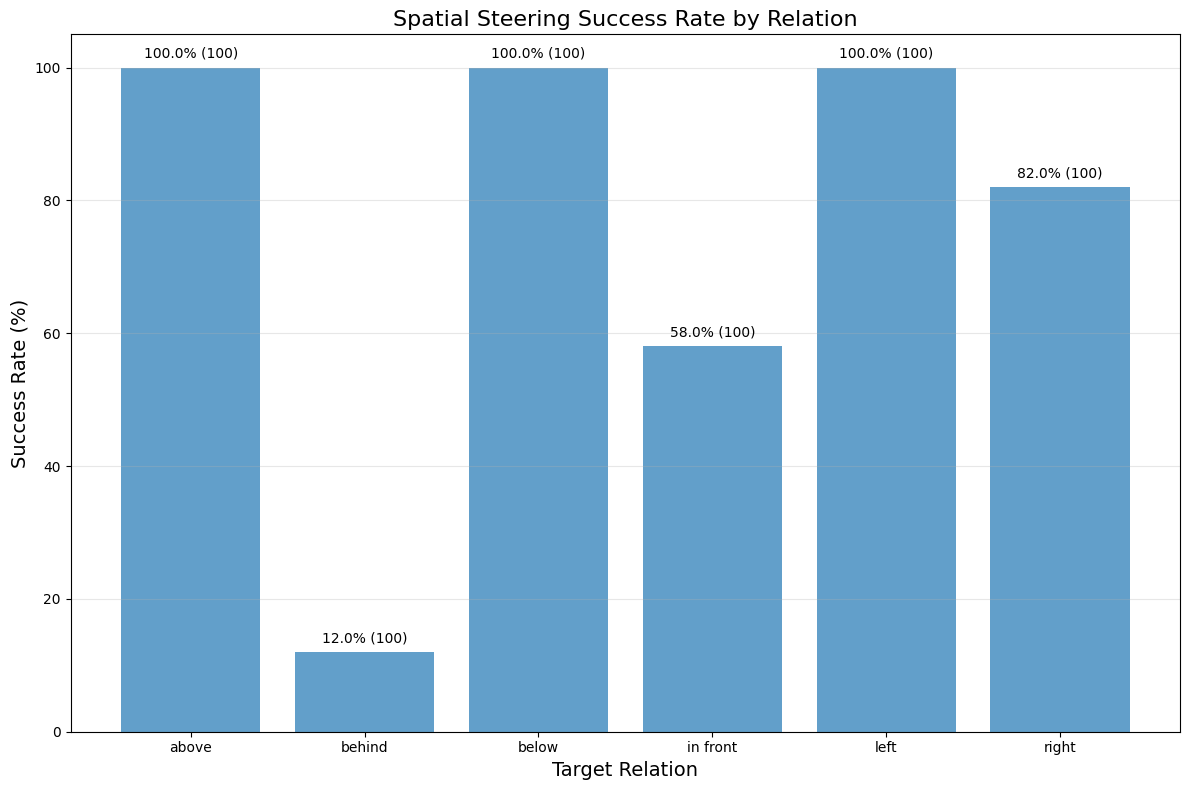

({'overall_success_rate': 0.7533333333333333,
  'confidence_interval': (np.float64(0.7188404681559064),
   np.float64(0.7878261985107602)),
  'by_relation': {'left': {'successes': 100, 'total': 100},
   'right': {'successes': 82, 'total': 100},
   'above': {'successes': 100, 'total': 100},
   'below': {'successes': 100, 'total': 100},
   'in front': {'successes': 58, 'total': 100},
   'behind': {'successes': 12, 'total': 100}},
  'detailed_results': [{'sentence': 'The cup is to the right of the plate. Where is the cup relative to the plate?',
    'source_relation': 'right',
    'target_relation': 'left',
    'target_key': 'left',
    'original_response': 'above',
    'steered_response': 'left',
    'success': True},
   {'sentence': 'The phone is to the right of the computer. Where is the phone relative to the computer?',
    'source_relation': 'right',
    'target_relation': 'left',
    'target_key': 'left',
    'original_response': 'left',
    'steered_response': 'left',
    'success'

In [ ]:
 def improved_steering_evaluation(model, tokenizer, steering_vectors, samples_per_relation=10):
    """
    Perform an improved evaluation of spatial steering to ensure all directions are tested.

    Args:
        model: Language model
        tokenizer: Model tokenizer
        steering_vectors: Steering vectors dictionary
        samples_per_relation: Number of test cases per target relation

    Returns:
        dict: Evaluation results
    """
    print(f"Starting improved steering evaluation with {samples_per_relation} samples per relation...")

    # Define relation pairs to test (opposites)
    relation_pairs = [
        ("left", "right"),
        ("above", "below"),
        ("in front", "behind")
    ]

    # Map to ensure consistent naming between relation text and vector keys
    relation_to_key = {
        "left": "left",
        "right": "right",
        "above": "above",
        "below": "below",
        "in front": "front",  # Map to the key used in steering_vectors
        "behind": "behind"
    }

    # Check which relations are available in the steering vectors
    available_relations = set(steering_vectors["optimized"].keys())
    print(f"Available optimized relations: {available_relations}")

    # Define common objects to use
    objects = [
        ("book", "vase"),
        ("lamp", "table"),
        ("car", "plant"),
        ("chair", "desk"),
        ("phone", "computer"),
        ("box", "shelf"),
        ("pen", "notebook"),
        ("cup", "plate"),
        ("picture", "wall"),
        ("remote", "television")
    ]

    # Create balanced test cases
    test_cases = []

    # For each target relation, create multiple test cases
    for rel_pair in relation_pairs:
        for target_idx in [0, 1]:  # Test both relations in each pair as targets
            source_idx = 1 - target_idx  # The other relation becomes the source

            source_rel = rel_pair[source_idx]
            target_rel = rel_pair[target_idx]
            target_key = relation_to_key.get(target_rel)

            # Skip if the target relation is not available in steering vectors
            if target_key not in available_relations:
                print(f"WARNING: Relation '{target_rel}' (key: '{target_key}') not available in steering vectors. Skipping.")
                continue

            # Create multiple test cases for this target relation
            for _ in range(samples_per_relation):
                obj1, obj2 = random.choice(objects)

                # Format the source relation properly
                if source_rel in ["in front", "behind"]:
                    rel_text = f"{source_rel} of"
                elif source_rel in ["left", "right"]:
                    rel_text = f"to the {source_rel} of"
                else:
                    rel_text = f"{source_rel}"

                # Create sentence with the source relation
                sentence = f"The {obj1} is {rel_text} the {obj2}. Where is the {obj1} relative to the {obj2}?"

                # Add to test cases with the target relation key
                test_cases.append({
                    "sentence": sentence,
                    "source_relation": source_rel,
                    "target_relation": target_rel,
                    "target_key": target_key
                })

    # Run tests
    results = []
    intervention = CausalIntervention(model, tokenizer)

    print(f"Running steering tests on {len(test_cases)} test cases...")
    for test_case in tqdm(test_cases):
        sentence = test_case["sentence"]
        target_relation = test_case["target_relation"]
        target_key = test_case["target_key"]

        # Get original response
        original_response = intervention.generate_response(sentence)

        # Apply steering
        try:
            # Get steering vector and configuration
            vector = steering_vectors["optimized"][target_key]["vector"].cuda()
            scale = steering_vectors["optimized"][target_key]["scale"]

            # Choose appropriate layers based on relation
            if target_key in ["above", "below"]:
                layers = [19, 24]
            elif target_key in ["left", "right"]:
                layers = [22, 24, 26]
            else:  # behind, front
                layers = [24, 27]

            # Apply hooks
            handles = []
            for layer_idx in layers:
                hook_fn = intervention.create_steering_hook(vector, layer_idx=layer_idx, scale_factor=scale)
                handle = model.model.layers[layer_idx].register_forward_hook(hook_fn)
                handles.append(handle)

            # Generate steered response
            steered_response = intervention.generate_response(sentence)

            # Remove hooks
            for handle in handles:
                handle.remove()

            # Check success (more flexible matching)
            success = False
            if target_relation == "in front":
                success = "front" in steered_response.lower()
            elif target_relation == "behind":
                success = "behind" in steered_response.lower() or "back" in steered_response.lower()
            else:
                success = target_relation.lower() in steered_response.lower()

            # Record result
            results.append({
                "sentence": sentence,
                "source_relation": test_case["source_relation"],
                "target_relation": target_relation,
                "target_key": target_key,
                "original_response": original_response,
                "steered_response": steered_response,
                "success": success
            })

            # Log detailed results for debugging
            print(f"\nTest case: {sentence}")
            print(f"Source relation: {test_case['source_relation']}")
            print(f"Target relation: {target_relation} (key: {target_key})")
            print(f"Original response: {original_response}")
            print(f"Steered response: {steered_response}")
            print(f"Success: {success}")

        except Exception as e:
            print(f"Error processing: {sentence}")
            print(f"Error: {e}")

    # Calculate overall statistics
    successes = sum(r["success"] for r in results)
    total = len(results)
    success_rate = successes / total if total > 0 else 0

    # Calculate confidence interval
    margin_of_error = 1.96 * np.sqrt((success_rate * (1 - success_rate)) / total)
    ci_low = max(0, success_rate - margin_of_error)
    ci_high = min(1, success_rate + margin_of_error)

    print(f"\nOverall success rate: {success_rate:.1%} (95% CI: {ci_low:.1%} - {ci_high:.1%})")

    # Group results by target relation
    by_relation = {}
    for r in results:
        rel = r["target_relation"]
        if rel not in by_relation:
            by_relation[rel] = {"successes": 0, "total": 0}
        by_relation[rel]["total"] += 1
        if r["success"]:
            by_relation[rel]["successes"] += 1

    # Calculate per-relation statistics
    print("\nResults by target relation:")
    for rel, stats in by_relation.items():
        rel_success_rate = stats["successes"] / stats["total"] if stats["total"] > 0 else 0
        print(f"{rel}: {rel_success_rate:.1%} ({stats['successes']}/{stats['total']})")

    return {
        "overall_success_rate": success_rate,
        "confidence_interval": (ci_low, ci_high),
        "by_relation": by_relation,
        "detailed_results": results
    }

# Enhanced function to visualize results
def visualize_steering_results(results):
    """
    Create visualizations of the steering evaluation results.

    Args:
        results: Results dictionary from improved_steering_evaluation
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Extract data
    relations = []
    success_rates = []
    sample_counts = []

    for rel, stats in results["by_relation"].items():
        relations.append(rel)
        success_rate = stats["successes"] / stats["total"] if stats["total"] > 0 else 0
        success_rates.append(success_rate * 100)
        sample_counts.append(stats["total"])

    # Sort by relation name
    sorted_indices = sorted(range(len(relations)), key=lambda i: relations[i])
    relations = [relations[i] for i in sorted_indices]
    success_rates = [success_rates[i] for i in sorted_indices]
    sample_counts = [sample_counts[i] for i in sorted_indices]

    # Plot success rates
    plt.figure(figsize=(12, 8))

    # Bar chart of success rates
    bars = plt.bar(relations, success_rates, alpha=0.7)

    # Add data labels on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{success_rates[i]:.1f}% ({sample_counts[i]})',
            ha='center', va='bottom', rotation=0
        )

    plt.title('Spatial Steering Success Rate by Relation', fontsize=16)
    plt.xlabel('Target Relation', fontsize=14)
    plt.ylabel('Success Rate (%)', fontsize=14)
    plt.ylim(0, 105)  # Leave room for labels
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    plt.savefig('steering_success_by_relation.png')
    plt.show()

    # Create a heatmap of source-target relations
    # Prepare data for heatmap
    source_relations = set(r["source_relation"] for r in results["detailed_results"])
    target_relations = set(r["target_relation"] for r in results["detailed_results"])

    # Sort them
    source_relations = sorted(source_relations)
    target_relations = sorted(target_relations)

    # Create matrix
    heatmap_data = np.zeros((len(source_relations), len(target_relations)))
    sample_matrix = np.zeros((len(source_relations), len(target_relations)))

    for r in results["detailed_results"]:
        source_idx = source_relations.index(r["source_relation"])
        target_idx = target_relations.index(r["target_relation"])
        if r["success"]:
            heatmap_data[source_idx, target_idx] += 1
        sample_matrix[source_idx, target_idx] += 1

    # Convert to success rates
    with np.errstate(divide='ignore', invalid='ignore'):
        success_matrix = np.divide(heatmap_data, sample_matrix) * 100
        success_matrix = np.nan_to_num(success_matrix)

    # # Plot heatmap
    # plt.figure(figsize=(12, 10))
    # sns.heatmap(
    #     success_matrix,
    #     annot=True,
    #     fmt='.1f',
    #     cmap='viridis',
    #     xticklabels=target_relations,
    #     yticklabels=source_relations
    # )
    # plt.title('Steering Success Rate by Source-Target Relation Pair (%)', fontsize=16)
    # plt.xlabel('Target Relation', fontsize=14)
    # plt.ylabel('Source Relation', fontsize=14)
    # plt.tight_layout()

    # plt.savefig('steering_success_heatmap.png')
    # plt.show()

    # Return for further analysis
    return {
        "relations": relations,
        "success_rates": success_rates,
        "sample_counts": sample_counts,
        "success_matrix": success_matrix,
        "source_relations": source_relations,
        "target_relations": target_relations
    }

# Usage example
def run_improved_evaluation():
    # Generate the enhanced steering vectors with force_new=True to ensure we don't use corrupted cache
    steering_vectors = generate_steering_vectors(probe, force_new=True)

    # Run the improved evaluation with 5 samples per relation
    results = improved_steering_evaluation(model, tokenizer, steering_vectors, samples_per_relation=100)

    # Visualize the results
    visualization_data = visualize_steering_results(results)

    return results, visualization_data

run_improved_evaluation()

# save result

In [ ]:
# !cp spatial_3d_probe.pt /content/drive/MyDrive/LLM_spatial_model_results
# !cp spatial_activations.pt /content/drive/MyDrive/LLM_spatial_model_results

# end